# Introduction

This file is an example script to run a population synthesis model similar to what is done in [Danti et. al (2023)](https://arxiv.org/abs/2310.02886), except now with disk winds. Note that many things about our model and Danti's model are different (like planet migration, chemistry, etc.), so we are not expecting the same results as Danti. Nevertheless, it is good to see how our results match up to Danti's, and it allows us to easily create new population synthesis scripts from this. 

Note, this script is designed to be informative, not fast. To produce results faster by running many disks in parallel (instead of sequentially, as done here), please use the run_model_pop_synth.py file contained in this same folder. Some basic instructions on running the file are attached at the end of run_model_pop_synth.py.  

Now, we can get to running the model! There are 3 components to running a DiscEvolution simulation:
- Defining your disc parameters
- Initializing the disc
- Evolving the disc (and saving data) until completion.

# Defining Disc Parameters

<p>We begin by defining disc parameters. Below, a "config" dictionary contains all of the parameters we need to run our disc. A simple breakdown of what each parameter does is shown through comments.</p>



In [4]:
config = {
    "grid": {
        "rmin": 1e-1, # minimum grid radius
        "rmax": 1000, # maximum grid radius
        "nr": 100, # number of bins in grid
        "spacing": "natural", # grid cell spacing
        "smart_bining": False, # removes bins further out where Sigma < 1e-4. 
        # Speeds up some simulations by removing bins with minimal contributions.
        "type": "winds-alpha" # Initialization method, discussed in next section.
    },
    "star": {
        "M": 1.0, # Solar masses
        "R": 2.5, # Solar radii
        "T_eff": 4000 # Kelvin
    },
    "simulation": {
        "t_initial": 0, # not used
        "t_final": 1e6, # not used
        "t_interval": [0, 0.1, 0.5, 1, 3], # Start point, save times, and end point of simulation
    },
    "disc": {
        "alpha": 1e-3, # total turbulent alpha. If using "-alpha" methods, is merely an initial guess.
        "M": [0.01, 0.05, 0.1], # disk mass as a percent of solar mass.
        "d2g": 0.01, # dust-to-gas ratio. Normally about 1%
        "Mdot": [1e-9, 1e-8, 1e-7], # accretion rate onto the star [M_sun/yr]
        "Sc": 1.0, # schmidt number, normally set to 1 (i.e., not effect)
        "Rd": [10, 50, 100], # characteristic radius of the disc. Used in defining the Sigma profile
        'gamma': 1 # power of the Sigma profile. Normally set to 1.
    },
    "eos": {
        "type": "IrradiatedEOS", # Class used to solve the temperature profile of the disc. 
        #Options are: IrradiatedEOS, LocallyIsothermalEOS, SimpleDiscEOS.
        "opacity": "Tazzari", # opacity class to use. Options are Tazzari or Zhu.
        "h0": 0.025, # aspect ratio at 1 AU in LocallyIsothermalEOS
        "q": -0.2 # exponent for speed of sound in LocallyIsothermalEOS
    },
    "transport": {
        "gas_transport": True, # whether gas should be evolved via viscous or disk wind means.
        "radial_drift": True, # whether pebbles should radially drift via drag. 
        "diffusion": True, # whether pebbles and gas should diffuse
        "van_leer": False # higher order DE solver for gas evolution. Normally, does not make much of a difference.
    },
    "dust_growth": {
        "feedback": True, # whether to have dust backreact onto the gas during drag interactions
        "settling": True, # whether to allow dust to settle towards the midplane (i.e., add dust from outside the midplain into the simulation over time).
        "f_ice": 1, # Ice fraction of pebbles. Used to calculate fragmentation velocity if chemistry is NOT on.
        "uf_0": 500,          # Fragmentation velocity for ice-free grains (cm/s)
        "uf_ice": 500,       # Set same as uf_0 to ignore ice effects
        "thresh": 0.5        # Set high threshold to prevent ice effects
    },
    "chemistry": {
        "on"   : True, 
        "fix_mu" : True, # not used
        "mu"     : 2.5, # not used
        "chem_model": "Equilibrium", # chemical model to use. Options are Equilibrium, Simple, and TimeDep
        "assert_d2g": True # fixes overall d2g of the entire disk to be what is assigned in "disc". Seemingly bugged.
    },
    "planets": {
        'include_planets': True,
        "planet_model": "Bitsch2015Model", # what planet model to use to evolve the disc. This is the only option so far.
        "Rp": [1, 5, 10, 20, 30], # initial position of embryo [AU]
        "Mp": [1e-2, 1e-2, 1e-2, 1e-2, 1e-2], # initial mass of embryo [M_Earth]
        "implant_time": [0, 0, 0, 0, 0], # time at which to place in embryos.
        "pb_gas_f": 0.1, # Percent of accreted solids that are added to the planet's envelope.
        "migrate" : True, # whether to turn on planet migration.
        "pebble_accretion": True, # whether to allow pebbles to accrete onto planets.
        "gas_accretion": True,  # whether to allow gas to accrete onto planets.
        "planetesimal_accretion": True # wheteher to allow planetesimals to accrete onto planets.
    },
    "planetesimal": {
        "active": True,
        "diameter": 200, # planetesimal diameter
        "St_min": 1e-2, # minimum stokes number of pebbles/grains that are allowed to form into planetesimals
        "St_max": 10, # maximum stokes number of pebbles/grains that are allowed to form into planetesimals
        "pla_eff": 0.05 # the percentage of passing pebbles/grains that are converted into planetesimals.
    },
    "winds": {
        "on": True,
        "psi_DW": [0.01, 1, 1000], # ratio of alpha_DW to alpha_SS. Stays fixed throughout the disk.
        "e_rad": 0.9 # radiative efficiency of the disk.
    }
}

# Initialization

Much of the procedure for initialization is extracted from Richard Booth's example codes. The most recent version of my initialization code is attached below, heavily commented to make it possible to follow the flow of logic. At a high level, we:

1. Extract parameters
2. Define a grid and star
3. Numerically solve the initial surface density profile given our initial parameters and preferred method. 
4. Initialize gas transport, dust drift, and diffusion.
5. Initialize "disc" class.
6. Initialize chemistry
7. Initialize planetesimals
8. Initialize and add planets.

<p>Note that many of these steps can be re-ordered (for example, planetesimals and planets), but this is the standard procedure I generally use.</p>

Now, my initialization for the population synthesis is shown below. I define a run_model function that I then call to run everything. A more standard way of doing it is using `PlanetDiscDriver` from driver.py (as done in Booth's example code or Sachen's example run file). Both achieve the same thing, I just did it this way for maximum control over my code during the development process. Also, it is easier to illustrate what exactly is happening during disc evolution this way.

Note that my run_model function below is broken up into chunks. This is done to allow me to interject with comments or clarifications. A complete run_model function is attached at the bottom of my example version (run that block to continue with the reproduction). 

In [5]:
import os
import json
import sys
# Add your path to the DiscEvolution directory
sys.path.append(os.path.abspath(os.path.join('..')) + '/')
sys.path.append('Insert/path/to/DiscEvolution')

import numpy as np
import matplotlib.pyplot as plt

from DiscEvolution.constants import *
from DiscEvolution.grid import Grid
from DiscEvolution.star import SimpleStar
from DiscEvolution.eos import IrradiatedEOS, LocallyIsothermalEOS, SimpleDiscEOS
from DiscEvolution.disc import *
from DiscEvolution.viscous_evolution import ViscousEvolution, ViscousEvolutionFV, LBP_Solution, HybridWindModel, TaboneSolution
from DiscEvolution.disc import AccretionDisc
from DiscEvolution.dust import *
from DiscEvolution.dust import PlanetesimalFormation
from DiscEvolution.planet_formation import *
from DiscEvolution.diffusion import TracerDiffusion
from DiscEvolution.opacity import Tazzari2016
from DiscEvolution.chemistry import *
from copy import deepcopy

import time
start_time = time.time()
plt.rcParams.update({'font.size': 16})

def run_model(config):
    """
    Run the disk evolution model and plot the results.
    
    Parameters:
    config (dict): Configuration dictionary containing all parameters.
    """
    # Extract parameters from config
    grid_params = config['grid']
    sim_params = config['simulation']
    star_params = config['star']
    disc_params = config['disc']
    eos_params = config['eos']
    transport_params = config['transport']
    dust_growth_params = config['dust_growth']
    planet_params = config['planets']
    chemistry_params = config["chemistry"]
    planetesimal_params = config['planetesimal']
    wind_params = config["winds"]
    
    # Set up disc
    # ========================

    # Create the grid
    grid = Grid(grid_params['rmin'], grid_params['rmax'], grid_params['nr'], spacing=grid_params['spacing'])
    
    # Create the star
    star = SimpleStar(M=star_params["M"], R=star_params["R"], T_eff=star_params['T_eff'])

    # Create time array (defining saving times to plot data)
    if sim_params['t_interval'] == "power":
        # Determine the number of points needed
        if sim_params['t_initial'] == 0:
            num_points = int(np.log10(sim_params['t_final'])) + 1
            times = np.logspace(0, np.log10(sim_params['t_final']), num=num_points) * 2 * np.pi
        else:
            num_points = int(np.log10(sim_params['t_final'] / sim_params['t_initial'])) + 1
            times = np.logspace(np.log10(sim_params['t_initial']), np.log10(sim_params['t_final']), num=num_points) * 2 * np.pi
    elif type(sim_params['t_interval']) == list:
        times = np.array(sim_params['t_interval']) * 2 * np.pi * 1e6
    else:
        times = np.arange(sim_params['t_initial'], sim_params['t_final'], sim_params['t_interval']) * 2 * np.pi

    # define opacity class used. If not Tazzari, defaults to Zhu in IrradiatedEOS.
    # Needs to be defined this early 
    if eos_params["opacity"] == "Tazzari":
        kappa = Tazzari2016()
    else:
        kappa = None

ModuleNotFoundError: No module named 'DiscEvolution'

Having done a little bit of initialization, we now pick a numerical method to solve for the surface density profile. 

For reasons that Michael can explain (I have forgotten the exact equations), defining 3 of $\dot{M}$, $M_{disk}$, $R_d$, and $\alpha$ specifies the last missing parameter and the surface density profile ($\Sigma$). As such, we need to specify/fix 3 of these 4 parameters, and then numerically sovle the last one and $\Sigma$. 

There are 2 sets of initialization methods we have developed, that being Booth and winds. There is also an LBP solution in case that is wanted. The Booth line of methods were created by Michael and edited by Sachen and I. They are made to initialize a purely viscous driven disk. The winds line of methods were created by Sachen and I, and are used to initialize disk wind and viscous driven (i.e. hybrid) disks. Under each set, there are 3 variations: "alpha", "Mdot", and "Rd". each variation's name specifies the missing parameter that will be solved numerically. So, for example, "Booth-alpha" is a viscous disk method that numerically solves for $\alpha$ and $\Sigma$ given $\dot{M}$, $M_{disk}$, and $R_d$. 

All of our initialization methods are attached below. You can specify your wanted method by changing the "type" parameter under grid configs. Note that "Booth-alpha" and "winds-alpha" are the methods I use the most, and thus are very up to date. The others may be outdated, so don't trust that they work perfectly. In my population synthesis, I use "winds-alpha". 

In [ ]:
def run_model(config): # placeholder to avoid errors when running the whole file
    if grid_params['type'] == 'Booth-alpha':
        # For fixed Rd, Mdot and Mdisk, solve for alpha
    
        # extract params
        Mdot=disc_params['Mdot']
        Mdisk=disc_params['M']
        alpha=disc_params['alpha']
        Rd=disc_params['Rd']
        R = grid.Rc

        def Sigma_profile(R, Rd, Mdisk):
            """Function that creates a non-steady state Sigma profile for gamma=1, scaled such that the disk mass equals Mdisk"""
            Sigma = (Rd/R) * np.exp(-R/Rd)
            Sigma *= Mdisk / (np.trapezoid(Sigma, np.pi * (R * AU)**2)/Msun)
            return Sigma
    
        # define an initial guess for the Sigma profile
        Sigma = Sigma_profile(R, Rd, Mdisk)
    
        # define a gas class, to be used later 
        gas_temp = ViscousEvolutionFV()

        # iterate to get alpha
        for j in range(100):
            # Create the EOS
            if eos_params["type"] == "SimpleDiscEOS":
                eos = SimpleDiscEOS(star, alpha_t=alpha)
            elif eos_params["type"] == "LocallyIsothermalEOS":
                eos = LocallyIsothermalEOS(star, eos_params['h0'], eos_params['q'], alpha)
            elif eos_params["type"] == "IrradiatedEOS":
                eos = IrradiatedEOS(star, alpha_t=alpha, kappa=kappa)
        
            # update eos with current sigma profile
            eos.set_grid(grid)
            eos.update(0, Sigma)

            # define a disc given current eos and Sigma
            disc = AccretionDisc(grid, star, eos, Sigma)

            # find the current Mdot in the disc
            Mdot_actual = disc.Mdot(gas_temp.viscous_velocity(disc, Sigma))

            # scale Sigma by Mdot to get desired Mdot.
            Sigma_new = Sigma*Mdot/Mdot_actual[0]
            Sigma = 0.5 * (Sigma + Sigma_new) # average done to damp oscillations in numerical solution

            # define new disc given new Sigma profile
            disc = AccretionDisc(grid, star, eos, Sigma)

            # scale alpha by Mdisk so that desired disk mass is achieved.
            alpha= alpha*(disc.Mtot()/Msun)/Mdisk

            if grid_params["smart_bining"]:
                # if using smart binning, re-create the grid and Sigma profile
                cutoff = np.where(Sigma < 1e-7)[0]
                
                if cutoff.shape == (0,):
                    continue

                grid_params['rmax'] = grid.Rc[cutoff[0]]
                grid_params['nr'] = cutoff[0]
                grid = Grid(grid_params['rmin'], grid_params['rmax'], grid_params['nr'], spacing=grid_params['spacing'])
                Sigma = np.split(Sigma, [cutoff[0]])[0]

    elif grid_params['type'] == 'Booth-Rd':
        # For fixed alpha, Mdot and Mdisk, solve for Rd
    
        # extract params
        Mdot=disc_params['Mdot']
        Mdisk=disc_params['M']
        alpha=disc_params['alpha']
        Rd=disc_params['Rd'] # initial guess
        R = grid.Rc

        def Sigma_profile(R, Rd, Mdisk):
            """Function that creates a non-steady state Sigma profile for gamma=1, scaled such that the disk mass equals Mdisk"""
            Sigma = (Rd/R) * np.exp(-R/Rd)
            Sigma *= Mdisk / (np.trapezoid(Sigma, np.pi * (R * AU)**2)/Msun)
            return Sigma
    
        # create an initial Sigma profile, scale by Mdisk
        Sigma = Sigma_profile(R, Rd, Mdisk)

        # Create the EOS
        if eos_params["type"] == "SimpleDiscEOS":
            eos = SimpleDiscEOS(star, alpha_t=alpha)
        elif eos_params["type"] == "LocallyIsothermalEOS":
            eos = LocallyIsothermalEOS(star, eos_params['h0'], eos_params['q'], alpha)
        elif eos_params["type"] == "IrradiatedEOS":
            eos = IrradiatedEOS(star, alpha_t=alpha, kappa=kappa)
        
        # update eos with guess Sigma
        eos.set_grid(grid)
        eos.update(0, Sigma)
    
        # define gas classe to be used in first iteration
        gas_temp = ViscousEvolutionFV()

        # iterate to get Rd
        for j in range(100):
            # initialize a disc with current Sigma and eos
            disc = AccretionDisc(grid, star, eos, Sigma)

            # find Mdot under current parameters
            Mdot_actual = disc.Mdot(gas_temp.viscous_velocity(disc, S=Sigma))

            # Scale Sigma to achieve the desired Mdot
            Sigma_new = Sigma*Mdot/Mdot_actual[0]
            Sigma = 0.5 * (Sigma + Sigma_new) # average done to damp oscillations in numerical solution

            # define a disk with new Sigma profile, use to scale R_d by disk mass
            disc = AccretionDisc(grid, star, eos, Sigma)
            Rd_new= Rd*np.sqrt(Mdisk/(disc.Mtot()/Msun))
            Rd = 0.5 * (Rd + Rd_new) # average done to damp oscillations in numerical solution

            # define new Sigma profile given new Rd
            Sigma = Sigma_profile(R, Rd, Mdisk)

            # update eos with new Sigma to have correct temperature profile
            eos.update(0, Sigma)

    elif grid_params['type'] == "LBP":
        # define viscous evolution to calculate drift velocity later
        gas = ViscousEvolutionFV()

        # extract parameters
        gamma=disc_params['gamma']
        R = grid.Rc
        Rd=disc_params['Rd']
        Mdot=disc_params['Mdot']* Msun/yr 
        Mdisk=disc_params['M']* Msun
        alpha=disc_params['alpha']
        mu=chemistry_params['mu']
        rin=R[0]
        xin=R[0]/Rd

        # calculate the keplerian velocity
        fin=np.exp(-xin**(2.-gamma))*(1.-2.*(2.-gamma)*xin**(2.-gamma))
        nud_goal=(Mdot/Mdisk)*(2.*Rd*Rd)/(3.*(2.-gamma))/fin*AU*AU #cm^2
        nud_cgs=nud_goal*yr/3.15e7
        Om_invsecond=star.Omega_k(Rd)*yr/3.15e7

        # calculate initial sound speed and temperature profile
        cs0 = np.sqrt(Om_invsecond*nud_cgs/alpha) #cm/s
        Td=cs0*cs0*mu*m_p/k_B #KT=Td*(R/Rd)**(gamma-1.5)
        T=Td*(R/Rd)**(gamma-1.5)

        # calculate the actual sound speed and surface density profile
        cs = np.sqrt(GasConst * T / mu) #cgs
        cs0 = np.sqrt(GasConst * Td / mu) #cgs
        nu=alpha*cs*cs/(star.Omega_k(R)*yr/3.15e7) # cm2/s
        nud=np.interp(Rd,grid.Rc,nu)*3.15e7/yr # cm^2 
        Sigma=LBP_Solution(Mdisk,Rd*AU,nud,gamma=gamma)
        Sigma0=Sigma(R*AU,0) 

        # Adjust alpha so initial Mdot is correct
        for i in range(10):
            # define an EOS
            eos = IrradiatedEOS(star, alpha_t=disc_params['alpha'], kappa=kappa)
            eos.set_grid(grid)
            eos.update(0, Sigma0)

            # define a temporary disc to compute Mdot
            disc = AccretionDisc(grid, star, eos, Sigma0)

            # adjust alpha depending on current Mdot and wanted Mdot
            vr=gas.viscous_velocity(disc,Sigma0)
            Mdot_actual=disc.Mdot(vr[0])#* (Msun / yr)
            alpha=alpha*(Mdot/Msun*yr)/Mdot_actual
        Sigma = Sigma0

    elif grid_params['type'] == 'Booth-Mdot':
        # For fixed alpha, Rd, and Mdisk, solve for Mdot
    
        # extract parameters
        R = grid.Rc
        Rd=disc_params['Rd']
        Mdot=disc_params['Mdot']* Msun/yr # initial guess
        Mdisk=disc_params['M']
        alpha=disc_params['alpha']

        # define Sigma profile, scale by Mdisk to get correct disk mass.
        Sigma = (Rd/R) * np.exp(-R/Rd)
        Sigma *= Mdisk / (np.trapezoid(Sigma, np.pi * (R * AU)**2)/Msun)

        # Create the EOS
        if eos_params["type"] == "SimpleDiscEOS":
            eos = SimpleDiscEOS(star, alpha_t=alpha)
        elif eos_params["type"] == "LocallyIsothermalEOS":
            eos = LocallyIsothermalEOS(star, eos_params['h0'], eos_params['q'], alpha)
        elif eos_params["type"] == "IrradiatedEOS":
            eos = IrradiatedEOS(star, alpha_t=alpha, kappa=kappa)
        
        # update the eos with relevant values
        eos.set_grid(grid)
        eos.update(0, Sigma)

    elif grid_params['type'] == 'winds-alpha':
        # For fixed Rd, Mdot and Mdisk, solve for alpha with disk winds
        # assumes gamma = 1

        # extract params
        Mdot=disc_params['Mdot'] # solar masses per year
        Mdisk=disc_params['M']* Msun
        psi = wind_params['psi_DW']
        #lambda_DW = wind_params['lambda_DW']
        Rd=disc_params['Rd']
        alpha = disc_params['alpha']
        e_rad=wind_params["e_rad"]
        Sc = disc_params["Sc"]
        gamma = disc_params['gamma']
        lambda_DW = 1/(2*(1 - e_rad)*(3/psi + 1)) + 1 
        R = grid.Rc
        alpha_SS = alpha/(1 + psi)

        # initial guess for Sigma
        Sigma_d = Mdisk/(2 * np.pi * (Rd*AU)**2)
        #xi = 0.25 * (1 + psi) * (np.sqrt(1 + 4*psi/((lambda_DW - 1) * (psi + 1)**2)) - 1)
        xi = 0
        Sigma = Sigma_d * (R/Rd)**(xi - gamma) * np.exp(-(R/Rd)**(2 - gamma))

        # define an initial disc and gas class to be used later
        disc = AccretionDisc(grid, star, eos=None, Sigma=Sigma)
        gas_temp = HybridWindModel(psi, lambda_DW)

        # scale Sigma by current Mtot just in case Sigma is not quite at the correct value to have the desired Mdisk (which often happens)
        Mtot = disc.Mtot()
        Sigma[:] *= Mdisk / Mtot

        for i in range(100):
            # Create the EOS
            if eos_params["type"] == "SimpleDiscEOS":
                eos = SimpleDiscEOS(star, alpha_t=alpha_SS)
            elif eos_params["type"] == "LocallyIsothermalEOS":
                eos = LocallyIsothermalEOS(star, eos_params['h0'], eos_params['q'], alpha_SS)
            elif eos_params["type"] == "IrradiatedEOS":
                eos = IrradiatedEOS(star, alpha_t=alpha_SS, kappa=kappa, psi=psi, e_rad=e_rad)
            
            # update eos with grid and Sigma
            eos.set_grid(grid)
            eos.update(0, Sigma)

            # define new disc 
            disc = AccretionDisc(grid,star,eos,Sigma)

            # find current Mdot in the disc given Sigma and current eos
            vr = gas_temp.viscous_velocity(disc,Sigma)
            Mdot_actual = disc.Mdot(vr)[0] # solar masses per year

            # Scale alpha by Mdot
            alpha_new = alpha*Mdot/Mdot_actual
            alpha = 0.5 * (alpha + alpha_new) # average done to damp oscillations in numerical solution

            # find a new alpha_SS given new alpha.
            alpha_SS = alpha/(1 + psi)

            if grid_params["smart_bining"]:
                # if using smart binning, re-create the grid and Sigma profile
                cutoff = np.where(Sigma < 1e-7)[0]
                
                if cutoff.shape == (0,):
                    continue

                grid_params['rmax'] = grid.Rc[cutoff[0]]
                grid_params['nr'] = cutoff[0]
                grid = Grid(grid_params['rmin'], grid_params['rmax'], grid_params['nr'], spacing=grid_params['spacing'])
                Sigma = np.split(Sigma, [cutoff[0]])[0]

    elif grid_params['type'] == 'winds-Rd':
        # For fixed alpha, Mdot and Mdisk, solve for Rd with disk winds
    
        # extract params
        Mdot=disc_params['Mdot'] # solar masses per year
        Mdisk=disc_params['M']* Msun
        psi = wind_params['psi_DW']
        #lambda_DW = wind_params['lambda_DW']
        Rd=disc_params['Rd']
        alpha = disc_params['alpha']
        Sc = disc_params["Sc"]
        gamma = disc_params['gamma']
        e_rad = wind_params["e_rad"]
        lambda_DW = 1/(2*(1 - e_rad)*(3/psi + 1)) + 1 
        R = grid.Rc
        alpha_SS = alpha/(1 + psi)

        def Sigma_profile(R, Rd, Mdisk):
            """Creates a non-steady state Sigma profile for gamma=1, scaled such that the disk mass equals Mdisk"""
            chi = 0.25 * (1 + psi) * (np.sqrt(1 + 4*psi/((lambda_DW - 1) * (psi + 1)**2)) - 1)
            Sigma = (R/Rd)**(chi - gamma) * np.exp(-(R/Rd)**(2 - gamma))
            Sigma *= Mdisk / np.trapezoid(Sigma, np.pi * (R * AU)**2)
            return Sigma
    
        # create an initial Sigma profile, scale by Mdisk
        Sigma = Sigma_profile(R, Rd, Mdisk)

        # Create the EOS
        if eos_params["type"] == "SimpleDiscEOS":
            eos = SimpleDiscEOS(star, alpha_t=alpha_SS)
        elif eos_params["type"] == "LocallyIsothermalEOS":
            eos = LocallyIsothermalEOS(star, eos_params['h0'], eos_params['q'], alpha_SS)
        elif eos_params["type"] == "IrradiatedEOS":
            eos = IrradiatedEOS(star, alpha_t=alpha_SS, kappa=kappa)
        
        # update eos with guess Sigma
        eos.set_grid(grid)
        eos.update(0, Sigma)
    
        # define gas classe to be used in first iteration
        gas_temp = HybridWindModel(psi, lambda_DW)

        # iterate to get Rd
        for j in range(100):
            # initialize a disc with current Sigma and eos
            disc = AccretionDisc(grid, star, eos, Sigma)

            # find Mdot under current parameters
            Mdot_actual = disc.Mdot(gas_temp.viscous_velocity(disc, S=Sigma))

            # Scale Sigma to achieve the desired Mdot
            Sigma_new = Sigma*Mdot/Mdot_actual[0]
            Sigma = 0.5 * (Sigma + Sigma_new) # average done to damp oscillations in numerical solution

            # define a disk with new Sigma profile, use to scale R_d by disk mass
            disc = AccretionDisc(grid, star, eos, Sigma)
            Rd_new= Rd*np.sqrt(Mdisk/disc.Mtot())
            Rd = 0.5 * (Rd + Rd_new) # average done to damp oscillations in numerical solution

            # define new Sigma profile given new Rd
            Sigma = Sigma_profile(R, Rd, Mdisk)

            # update eos with new Sigma to have correct temperature profile
            eos.update(0, Sigma)

    elif grid_params['type'] == 'winds-Mdot':
        # For fixed alpha, Rd, and Mdisk, solve for Mdot with disk winds included
    
        # extract parameters
        R = grid.Rc
        Rd=disc_params['Rd']
        Mdot=disc_params['Mdot'] # initial guess
        Mdisk=disc_params['M']
        alpha=disc_params['alpha']
        psi = wind_params['psi_DW']
        e_rad = wind_params["e_rad"]
        lambda_DW = 1/(2*(1 - e_rad)*(3/psi + 1)) + 1 
        gamma = disc_params['gamma']
        alpha_SS = alpha/(1+psi)

        # define Sigma profile, scale by Mdisk to get correct disk mass.
        chi = 0.25 * (1 + psi) * (np.sqrt(1 + 4*psi/((lambda_DW - 1) * (psi + 1)**2)) - 1)
        Sigma = (R/Rd)**(chi - gamma) * np.exp(-(R/Rd)**(2 - gamma))
        Sigma *= Mdisk / (np.trapezoid(Sigma, np.pi * (R * AU)**2)/Msun)

        # Create the EOS
        if eos_params["type"] == "SimpleDiscEOS":
            eos = SimpleDiscEOS(star, alpha_t=alpha_SS)
        elif eos_params["type"] == "LocallyIsothermalEOS":
            eos = LocallyIsothermalEOS(star, eos_params['h0'], eos_params['q'], alpha_SS)
        elif eos_params["type"] == "IrradiatedEOS":
            eos = IrradiatedEOS(star, alpha_t=alpha_SS, kappa=kappa, psi=psi, e_rad=e_rad)
        
        # update the eos with relevant values
        eos.set_grid(grid)
        eos.update(0, Sigma)

Now, we initialize the rest!

In [ ]:
def run_model(config): # placeholder to avoid errors when running the whole file
    # Set up dynamics
    # ========================
    gas = None
    if transport_params['gas_transport']:
        if wind_params["on"]:
            gas = HybridWindModel(wind_params['psi_DW'], lambda_DW)
        else:
            gas = ViscousEvolutionFV()
    
    diffuse = None
    if transport_params['diffusion']:
        diffuse = TracerDiffusion(Sc=disc_params["Sc"])

    dust = None
    if transport_params['radial_drift']:
        dust = SingleFluidDrift(diffusion=diffuse, settling=dust_growth_params["settling"], van_leer=transport_params['van_leer'])
        diffuse = None

    # Set disc model
    # ========================
    try:
        disc = DustGrowthTwoPop(grid, star, eos, disc_params['d2g'], 
            Sigma=Sigma, feedback=dust_growth_params["feedback"], Sc=disc_params["Sc"],
            f_ice=dust_growth_params['f_ice'], thresh=dust_growth_params['thresh'],
            uf_0=dust_growth_params["uf_0"], uf_ice=dust_growth_params["uf_ice"], gas=gas
        )
    except Exception as e:
        #disc = DustGrowthTwoPop(grid, star, eos, disc_params['d2g'], Sigma=Sigma, f_ice=dust_growth_params['f_ice'], thresh=dust_growth_params['thresh'])
        raise e

    # Set up Chemistry
    # =======================
    if chemistry_params["on"]:

        # extract params
        N_cell = grid_params["nr"]
        T =  eos.T
        n = Sigma / (2.4*m_H)

        # choose chemical model
        if chemistry_params["chem_model"] == "Simple":
            chemistry = SimpleCOChemOberg()
        elif chemistry_params["chem_model"] == "Equilibrium":
            chemistry = EquilibriumCOChemOberg(fix_ratios=False, a=1e-5)
        elif chemistry_params["chem_model"] == "TimeDep":
            chemistry = TimeDepCOChemOberg(a=1e-5)
        else:
            raise Exception("Valid chemistry model not selected. Choose Simple, Equilibrium, or TimeDep")
        
        # Setup the dust-to-gas ratio from the chemistry
        X_solar = SimpleCOAtomAbund(N_cell) # data array containing abundances of atoms
        X_solar.set_solar_abundances() # redefines abundances by multiplying with specific constants

        # Iterate ice fractions to get the dust-to-gas ratio:
        for i in range(100):
            if chemistry_params["assert_d2g"]:

                # find the total gas and dust mass.
                M_dust = np.trapezoid(disc.Sigma_D.sum(0), np.pi*grid.Rc**2)
                M_gas = np.trapezoid(disc.Sigma_G, np.pi*grid.Rc**2)

                # calculate a modification fraction by dividing the wanted dust fraction by the current dust fraction.
                mod_frac = disc_params["d2g"]/(M_dust/M_gas)

                # multiply modification fraction into dust fraction to assert wanted dust fraction.
                disc.dust_frac[:] = disc.dust_frac*mod_frac

            if disc._planetesimal:
                dust_frac = disc.dust_frac[:-1].sum(0)  # exclude planetesimals
            else:
                dust_frac = disc.dust_frac.sum(0)
            
            # Returns MolecularIceAbund class containing SimpleCOMolAbund for gas and ice
            chem = chemistry.equilibrium_chem(disc.T, 
                                            disc.midplane_gas_density,
                                            dust_frac,
                                            X_solar)
            disc.initialize_dust_density(chem.ice.total_abund)
        disc.chem = chem

        disc.update_ices(disc.chem.ice)

    # Set up planetesimals
    # ========================
    disc._planetesimal = None
    if planetesimal_params['active']:
        disc._planetesimal = PlanetesimalFormation(
            disc, 
            d_planetesimal=planetesimal_params['diameter'], 
            St_min=planetesimal_params['St_min'], 
            St_max=planetesimal_params['St_max'], 
            pla_eff=planetesimal_params['pla_eff']
        )

    # Set up planet(s)
    # ========================
    if planet_params['include_planets']:
        
        if chemistry_params["on"]:
            Nchem=disc.chem.ice.data.shape[0]
            planets = Planets(Nchem=Nchem)
        else:
            planets = Planets(Nchem=0)
        
        planet_model = Bitsch2015Model(
            disc, pb_gas_f=planet_params["pb_gas_f"], 
            migrate=planet_params["migrate"], 
            pebble_accretion=planet_params["pebble_accretion"],
            gas_accretion=planet_params["gas_accretion"],
            planetesimal_accretion=planet_params["planetesimal_accretion"],
            winds = wind_params["on"]
        )
        planet_model.set_disc(disc)

        Mp = planet_params['Mp']
        Rp = planet_params['Rp']
        for i in range(len(Mp)):
            if chemistry_params["on"]:
                # we assume planets start with no envelope
                X_core = []

                for d, ice_spec in enumerate(disc.chem.ice.data):
                    X_core.append(disc.interp(Rp[i], ice_spec)/disc.interp(Rp[i], disc.dust_frac[:2].sum(0)))

                X_core = np.array(X_core)
                X_env = np.zeros(X_core.shape)

                planets.add_planet(planet_params["implant_time"][i], Rp[i], Mp[i], 0, X_core, X_env)
            else:
                planets.add_planet(planet_params["implant_time"][i], Rp[i], Mp[i], 0)

        time_keeper = []
        Rs, Mcs, Mes, Mdot_tracker, X_cores, X_envs = [], [], [], [], [], []

        for i, planet in enumerate(planets):
            Rs.append([])
            Mcs.append([])
            Mes.append([])
            Mdot_tracker.append([])

            if chemistry_params["on"]:
                X_cores.append([[] for num in range(0, Nchem, 1)]) 
                X_envs.append([[] for num in range(0, Nchem, 1)])
        
        # first data point
        for count, planet in enumerate(planets):
            Rs[count].append(planet.R.copy())
            Mcs[count].append(planet.M_core.copy())
            Mes[count].append(planet.M_env.copy())
            #Mdot_tracker[count].append(planet_model._peb_acc.computeMdot(planet.R, planet.M))
            if chemistry_params["on"]:
                for count2, chem in enumerate(planet.X_core):
                    X_cores[count][count2].append(chem)
                    X_envs[count][count2].append(planet.X_env[count2])
        time_keeper.append(0)

# Evolving the Disc

Finally, we can evolve the disc by looping over timesteps until we reach the final save time. Our evolution code is attached below. 



In [ ]:
def run_model(config): # placeholder to avoid errors when running the whole file
    # Run model
    # ========================
    t = 0
    n = 0

    for ti in times:

        if alpha_SS > 5e-3:
            break

        while t < ti:
            # find timestep given gas and dust maximum timesteps
            dt = ti - t
            if transport_params['gas_transport']:
                dt = min(dt, gas.max_timestep(disc))
            if transport_params['radial_drift']:
                dt = min(dt, dust.max_timestep(disc))
            
            # Extract updated dust frac to update gas
            dust_frac = None
            try:
                dust_frac = disc.dust_frac
            except AttributeError:
                pass

            # Extract gas tracers
            gas_chem, ice_chem = None, None
            try:
                gas_chem = disc.chem.gas.data
                ice_chem = disc.chem.ice.data
            except AttributeError:
                pass

            # Do gas evolution
            if transport_params['gas_transport']:
                
                # to preserve planetesimal surface density so 
                # that it doesn't move with a change in Sigma 
                # as a whole, we do the following:
                if disc._planetesimal:
                    gas(dt, disc, [dust_frac[:-1], gas_chem, ice_chem])
                else:
                    gas(dt, disc, [dust_frac, gas_chem, ice_chem])

            # Do dust evolution
            if transport_params['radial_drift']:
                if disc._planetesimal:
                    dust(dt, disc, gas_tracers=gas_chem, dust_tracers=ice_chem)
                else:
                    dust(dt, disc, gas_tracers=gas_chem, dust_tracers=ice_chem)

            if diffuse is not None:
                if gas_chem is not None:
                    gas_chem[:] += dt * diffuse(disc, gas_chem)
                if ice_chem is not None:
                    ice_chem[:] += dt * diffuse(disc, ice_chem)
                if dust_frac is not None:
                    if disc._planetesimal:
                        # excluding planetesimals (assuming they don't diffuse significantly)
                        dust_frac[:-1] += dt * diffuse(disc, dust_frac[:-1]) 
                    else: 
                        dust_frac[:] += dt * diffuse(disc, dust_frac[:])

            # Pin the values to >= 0 and <=1:
            disc.Sigma[:] = np.maximum(disc.Sigma, 0)     
            disc.dust_frac[:] = np.maximum(disc.dust_frac, 0)
            disc.dust_frac[:] /= np.maximum(disc.dust_frac.sum(0), 1.0)
            if chemistry_params["on"]:
                disc.chem.gas.data[:] = np.maximum(disc.chem.gas.data, 0)
                disc.chem.ice.data[:] = np.maximum(disc.chem.ice.data, 0)

            if disc._planetesimal:
                disc._planetesimal.update(dt, disc, dust)

            if chemistry_params["on"]:
                # exclude planetesimals from chemistry (assume they don't chemically interact with the disc)
                if disc._planetesimal:
                    chemistry.update(dt, disc.T, disc.midplane_gas_density, disc.dust_frac[:-1].sum(0), disc.chem)
                else:
                    chemistry.update(dt, disc.T, disc.midplane_gas_density, disc.dust_frac.sum(0), disc.chem)
                
                disc.update_ices(disc.chem.ice)

            if planet_params['include_planets']:
                # Update the planet masses and radii
                planet_model.integrate(dt, planets) 

            # update disc
            disc.update(dt)
            
            # increase time and go forward a steo
            t += dt
            n += 1

            if (n % 1000) == 0:
                print('\rNstep: {}'.format(n), end="", flush="True")
                print('\rTime: {} yr'.format(t / (2 * np.pi)), end="", flush="True")
                print('\rdt: {} yr'.format(dt / (2 * np.pi)), end="", flush="True")
            
            if planet_params['include_planets']:

                # Collect data for planet growth track and chemistry
                if n % 1000 == 0:
                    for count, planet in enumerate(planets):
                        Rs[count].append(planet.R.copy())
                        Mcs[count].append(planet.M_core.copy())
                        Mes[count].append(planet.M_env.copy())
                        if chemistry_params["on"]:
                            for count2, chem in enumerate(planet.X_core):
                                X_cores[count][count2].append(chem)
                                X_envs[count][count2].append(planet.X_env[count2])
                    time_keeper.append(t/(2*np.pi))

    # filtering out unrealistic viscous alphas in our population synthesis
    if not alpha_SS > 5e-3:
        # Storing last data points before saving into data dictionary
        for count, planet in enumerate(planets):
            Rs[count].append(planet.R.copy())
            Mcs[count].append(planet.M_core.copy())
            Mes[count].append(planet.M_env.copy())
            if chemistry_params["on"]:
                for count2, chem in enumerate(planet.X_core):
                    X_cores[count][count2].append(chem)
                    X_envs[count][count2].append(planet.X_env[count2])
            time_keeper.append(t/(2*np.pi))

        data = {}
        data["t"] = time_keeper
        data["Mcs"] = Mcs
        data["Mes"] = Mes
        data["Rp"] = Rs
        data["X_cores"] = X_cores
        data["X_envs"] = X_envs
        data["alpha_SS"] = alpha_SS

        if not wind_params["on"]:
            wind_params["psi_DW"] = 0

        with open(f"data/winds_mig_psi{wind_params["psi_DW"]}_Mdot{disc_params["Mdot"]:.1e}_M{disc_params["M"]:.1e}_Rd{disc_params["Rd"]:.1e}.json", "w") as out:
            out.write(json.dumps(data))

And that's everything needed to run the model! A complete version of the above run model script is attached below so that you can run it for a population synthesis. I suggest collapsing the below cell (by clicking the orange bar on the left) so that it doesn't take up space. 

In [ ]:
import os
import json
import sys
# Add your path to the DiscEvolution directory
sys.path.append(os.path.abspath(os.path.join('..')) + '/')
sys.path.append('Insert/path/to/DiscEvolution')

import numpy as np
import matplotlib.pyplot as plt

from DiscEvolution.constants import *
from DiscEvolution.grid import Grid
from DiscEvolution.star import SimpleStar
from DiscEvolution.eos import IrradiatedEOS, LocallyIsothermalEOS, SimpleDiscEOS
from DiscEvolution.disc import *
from DiscEvolution.viscous_evolution import ViscousEvolution, ViscousEvolutionFV, LBP_Solution, HybridWindModel, TaboneSolution
from DiscEvolution.disc import AccretionDisc
from DiscEvolution.dust import *
from DiscEvolution.dust import PlanetesimalFormation
from DiscEvolution.planet_formation import *
from DiscEvolution.diffusion import TracerDiffusion
from DiscEvolution.opacity import Tazzari2016
from DiscEvolution.chemistry import *
from copy import deepcopy

import time
start_time = time.time()
plt.rcParams.update({'font.size': 16})

def run_model(config):
    """
    Run the disk evolution model and plot the results.
    
    Parameters:
    config (dict): Configuration dictionary containing all parameters.
    """
    # Extract parameters from config
    grid_params = config['grid']
    sim_params = config['simulation']
    star_params = config['star']
    disc_params = config['disc']
    eos_params = config['eos']
    transport_params = config['transport']
    dust_growth_params = config['dust_growth']
    planet_params = config['planets']
    chemistry_params = config["chemistry"]
    planetesimal_params = config['planetesimal']
    wind_params = config["winds"]
    
    # Set up disc
    # ========================

    # Create the grid
    grid = Grid(grid_params['rmin'], grid_params['rmax'], grid_params['nr'], spacing=grid_params['spacing'])
    
    # Create the star
    star = SimpleStar(M=star_params["M"], R=star_params["R"], T_eff=star_params['T_eff'])

    # Create time array (defining saving times to plot data)
    if sim_params['t_interval'] == "power":
        # Determine the number of points needed
        if sim_params['t_initial'] == 0:
            num_points = int(np.log10(sim_params['t_final'])) + 1
            times = np.logspace(0, np.log10(sim_params['t_final']), num=num_points) * 2 * np.pi
        else:
            num_points = int(np.log10(sim_params['t_final'] / sim_params['t_initial'])) + 1
            times = np.logspace(np.log10(sim_params['t_initial']), np.log10(sim_params['t_final']), num=num_points) * 2 * np.pi
    elif type(sim_params['t_interval']) == list:
        times = np.array(sim_params['t_interval']) * 2 * np.pi * 1e6
    else:
        times = np.arange(sim_params['t_initial'], sim_params['t_final'], sim_params['t_interval']) * 2 * np.pi

    # define opacity class used. If not Tazzari, defaults to Zhu in IrradiatedEOS.
    # Needs to be defined this early 
    if eos_params["opacity"] == "Tazzari":
        kappa = Tazzari2016()
    else:
        kappa = None

    if grid_params['type'] == 'Booth-alpha':
        # For fixed Rd, Mdot and Mdisk, solve for alpha
    
        # extract params
        Mdot=disc_params['Mdot']
        Mdisk=disc_params['M']
        alpha=disc_params['alpha']
        Rd=disc_params['Rd']
        R = grid.Rc

        def Sigma_profile(R, Rd, Mdisk):
            """Function that creates a non-steady state Sigma profile for gamma=1, scaled such that the disk mass equals Mdisk"""
            Sigma = (Rd/R) * np.exp(-R/Rd)
            Sigma *= Mdisk / (np.trapezoid(Sigma, np.pi * (R * AU)**2)/Msun)
            return Sigma
    
        # define an initial guess for the Sigma profile
        Sigma = Sigma_profile(R, Rd, Mdisk)
    
        # define a gas class, to be used later 
        gas_temp = ViscousEvolutionFV()

        # iterate to get alpha
        for j in range(100):
            # Create the EOS
            if eos_params["type"] == "SimpleDiscEOS":
                eos = SimpleDiscEOS(star, alpha_t=alpha)
            elif eos_params["type"] == "LocallyIsothermalEOS":
                eos = LocallyIsothermalEOS(star, eos_params['h0'], eos_params['q'], alpha)
            elif eos_params["type"] == "IrradiatedEOS":
                eos = IrradiatedEOS(star, alpha_t=alpha, kappa=kappa)
        
            # update eos with current sigma profile
            eos.set_grid(grid)
            eos.update(0, Sigma)

            # define a disc given current eos and Sigma
            disc = AccretionDisc(grid, star, eos, Sigma)

            # find the current Mdot in the disc
            Mdot_actual = disc.Mdot(gas_temp.viscous_velocity(disc, Sigma))

            # scale Sigma by Mdot to get desired Mdot.
            Sigma_new = Sigma*Mdot/Mdot_actual[0]
            Sigma = 0.5 * (Sigma + Sigma_new) # average done to damp oscillations in numerical solution

            # define new disc given new Sigma profile
            disc = AccretionDisc(grid, star, eos, Sigma)

            # scale alpha by Mdisk so that desired disk mass is achieved.
            alpha= alpha*(disc.Mtot()/Msun)/Mdisk

            if grid_params["smart_bining"]:
                # if using smart binning, re-create the grid and Sigma profile
                cutoff = np.where(Sigma < 1e-7)[0]
                
                if cutoff.shape == (0,):
                    continue

                grid_params['rmax'] = grid.Rc[cutoff[0]]
                grid_params['nr'] = cutoff[0]
                grid = Grid(grid_params['rmin'], grid_params['rmax'], grid_params['nr'], spacing=grid_params['spacing'])
                Sigma = np.split(Sigma, [cutoff[0]])[0]

    elif grid_params['type'] == 'Booth-Rd':
        # For fixed alpha, Mdot and Mdisk, solve for Rd
    
        # extract params
        Mdot=disc_params['Mdot']
        Mdisk=disc_params['M']
        alpha=disc_params['alpha']
        Rd=disc_params['Rd'] # initial guess
        R = grid.Rc

        def Sigma_profile(R, Rd, Mdisk):
            """Function that creates a non-steady state Sigma profile for gamma=1, scaled such that the disk mass equals Mdisk"""
            Sigma = (Rd/R) * np.exp(-R/Rd)
            Sigma *= Mdisk / (np.trapezoid(Sigma, np.pi * (R * AU)**2)/Msun)
            return Sigma
    
        # create an initial Sigma profile, scale by Mdisk
        Sigma = Sigma_profile(R, Rd, Mdisk)

        # Create the EOS
        if eos_params["type"] == "SimpleDiscEOS":
            eos = SimpleDiscEOS(star, alpha_t=alpha)
        elif eos_params["type"] == "LocallyIsothermalEOS":
            eos = LocallyIsothermalEOS(star, eos_params['h0'], eos_params['q'], alpha)
        elif eos_params["type"] == "IrradiatedEOS":
            eos = IrradiatedEOS(star, alpha_t=alpha, kappa=kappa)
        
        # update eos with guess Sigma
        eos.set_grid(grid)
        eos.update(0, Sigma)
    
        # define gas classe to be used in first iteration
        gas_temp = ViscousEvolutionFV()

        # iterate to get Rd
        for j in range(100):
            # initialize a disc with current Sigma and eos
            disc = AccretionDisc(grid, star, eos, Sigma)

            # find Mdot under current parameters
            Mdot_actual = disc.Mdot(gas_temp.viscous_velocity(disc, S=Sigma))

            # Scale Sigma to achieve the desired Mdot
            Sigma_new = Sigma*Mdot/Mdot_actual[0]
            Sigma = 0.5 * (Sigma + Sigma_new) # average done to damp oscillations in numerical solution

            # define a disk with new Sigma profile, use to scale R_d by disk mass
            disc = AccretionDisc(grid, star, eos, Sigma)
            Rd_new= Rd*np.sqrt(Mdisk/(disc.Mtot()/Msun))
            Rd = 0.5 * (Rd + Rd_new) # average done to damp oscillations in numerical solution

            # define new Sigma profile given new Rd
            Sigma = Sigma_profile(R, Rd, Mdisk)

            # update eos with new Sigma to have correct temperature profile
            eos.update(0, Sigma)

    elif grid_params['type'] == "LBP":
        # define viscous evolution to calculate drift velocity later
        gas = ViscousEvolutionFV()

        # extract parameters
        gamma=disc_params['gamma']
        R = grid.Rc
        Rd=disc_params['Rd']
        Mdot=disc_params['Mdot']* Msun/yr 
        Mdisk=disc_params['M']* Msun
        alpha=disc_params['alpha']
        mu=chemistry_params['mu']
        rin=R[0]
        xin=R[0]/Rd

        # calculate the keplerian velocity
        fin=np.exp(-xin**(2.-gamma))*(1.-2.*(2.-gamma)*xin**(2.-gamma))
        nud_goal=(Mdot/Mdisk)*(2.*Rd*Rd)/(3.*(2.-gamma))/fin*AU*AU #cm^2
        nud_cgs=nud_goal*yr/3.15e7
        Om_invsecond=star.Omega_k(Rd)*yr/3.15e7

        # calculate initial sound speed and temperature profile
        cs0 = np.sqrt(Om_invsecond*nud_cgs/alpha) #cm/s
        Td=cs0*cs0*mu*m_p/k_B #KT=Td*(R/Rd)**(gamma-1.5)
        T=Td*(R/Rd)**(gamma-1.5)

        # calculate the actual sound speed and surface density profile
        cs = np.sqrt(GasConst * T / mu) #cgs
        cs0 = np.sqrt(GasConst * Td / mu) #cgs
        nu=alpha*cs*cs/(star.Omega_k(R)*yr/3.15e7) # cm2/s
        nud=np.interp(Rd,grid.Rc,nu)*3.15e7/yr # cm^2 
        Sigma=LBP_Solution(Mdisk,Rd*AU,nud,gamma=gamma)
        Sigma0=Sigma(R*AU,0) 

        # Adjust alpha so initial Mdot is correct
        for i in range(10):
            # define an EOS
            eos = IrradiatedEOS(star, alpha_t=disc_params['alpha'], kappa=kappa)
            eos.set_grid(grid)
            eos.update(0, Sigma0)

            # define a temporary disc to compute Mdot
            disc = AccretionDisc(grid, star, eos, Sigma0)

            # adjust alpha depending on current Mdot and wanted Mdot
            vr=gas.viscous_velocity(disc,Sigma0)
            Mdot_actual=disc.Mdot(vr[0])#* (Msun / yr)
            alpha=alpha*(Mdot/Msun*yr)/Mdot_actual
        Sigma = Sigma0

    elif grid_params['type'] == 'Booth-Mdot':
        # For fixed alpha, Rd, and Mdisk, solve for Mdot
    
        # extract parameters
        R = grid.Rc
        Rd=disc_params['Rd']
        Mdot=disc_params['Mdot']* Msun/yr # initial guess
        Mdisk=disc_params['M']
        alpha=disc_params['alpha']

        # define Sigma profile, scale by Mdisk to get correct disk mass.
        Sigma = (Rd/R) * np.exp(-R/Rd)
        Sigma *= Mdisk / (np.trapezoid(Sigma, np.pi * (R * AU)**2)/Msun)

        # Create the EOS
        if eos_params["type"] == "SimpleDiscEOS":
            eos = SimpleDiscEOS(star, alpha_t=alpha)
        elif eos_params["type"] == "LocallyIsothermalEOS":
            eos = LocallyIsothermalEOS(star, eos_params['h0'], eos_params['q'], alpha)
        elif eos_params["type"] == "IrradiatedEOS":
            eos = IrradiatedEOS(star, alpha_t=alpha, kappa=kappa)
        
        # update the eos with relevant values
        eos.set_grid(grid)
        eos.update(0, Sigma)

    elif grid_params['type'] == 'winds-alpha':
        # For fixed Rd, Mdot and Mdisk, solve for alpha with disk winds
        # assumes gamma = 1

        # extract params
        Mdot=disc_params['Mdot'] # solar masses per year
        Mdisk=disc_params['M']* Msun
        psi = wind_params['psi_DW']
        #lambda_DW = wind_params['lambda_DW']
        Rd=disc_params['Rd']
        alpha = disc_params['alpha']
        e_rad=wind_params["e_rad"]
        Sc = disc_params["Sc"]
        gamma = disc_params['gamma']
        lambda_DW = 1/(2*(1 - e_rad)*(3/psi + 1)) + 1 
        R = grid.Rc
        alpha_SS = alpha/(1 + psi)

        # initial guess for Sigma
        Sigma_d = Mdisk/(2 * np.pi * (Rd*AU)**2)
        #xi = 0.25 * (1 + psi) * (np.sqrt(1 + 4*psi/((lambda_DW - 1) * (psi + 1)**2)) - 1)
        xi = 0
        Sigma = Sigma_d * (R/Rd)**(xi - gamma) * np.exp(-(R/Rd)**(2 - gamma))

        # define an initial disc and gas class to be used later
        disc = AccretionDisc(grid, star, eos=None, Sigma=Sigma)
        gas_temp = HybridWindModel(psi, lambda_DW)

        # scale Sigma by current Mtot just in case Sigma is not quite at the correct value to have the desired Mdisk (which often happens)
        Mtot = disc.Mtot()
        Sigma[:] *= Mdisk / Mtot

        for i in range(100):
            # Create the EOS
            if eos_params["type"] == "SimpleDiscEOS":
                eos = SimpleDiscEOS(star, alpha_t=alpha_SS)
            elif eos_params["type"] == "LocallyIsothermalEOS":
                eos = LocallyIsothermalEOS(star, eos_params['h0'], eos_params['q'], alpha_SS)
            elif eos_params["type"] == "IrradiatedEOS":
                eos = IrradiatedEOS(star, alpha_t=alpha_SS, kappa=kappa, psi=psi, e_rad=e_rad)
            
            # update eos with grid and Sigma
            eos.set_grid(grid)
            eos.update(0, Sigma)

            # define new disc 
            disc = AccretionDisc(grid,star,eos,Sigma)

            # find current Mdot in the disc given Sigma and current eos
            vr = gas_temp.viscous_velocity(disc,Sigma)
            Mdot_actual = disc.Mdot(vr)[0] # solar masses per year

            # Scale alpha by Mdot
            alpha_new = alpha*Mdot/Mdot_actual
            alpha = 0.5 * (alpha + alpha_new) # average done to damp oscillations in numerical solution

            # find a new alpha_SS given new alpha.
            alpha_SS = alpha/(1 + psi)

            if grid_params["smart_bining"]:
                # if using smart binning, re-create the grid and Sigma profile
                cutoff = np.where(Sigma < 1e-7)[0]
                
                if cutoff.shape == (0,):
                    continue

                grid_params['rmax'] = grid.Rc[cutoff[0]]
                grid_params['nr'] = cutoff[0]
                grid = Grid(grid_params['rmin'], grid_params['rmax'], grid_params['nr'], spacing=grid_params['spacing'])
                Sigma = np.split(Sigma, [cutoff[0]])[0]

    elif grid_params['type'] == 'winds-Rd':
        # For fixed alpha, Mdot and Mdisk, solve for Rd with disk winds
    
        # extract params
        Mdot=disc_params['Mdot'] # solar masses per year
        Mdisk=disc_params['M']* Msun
        psi = wind_params['psi_DW']
        #lambda_DW = wind_params['lambda_DW']
        Rd=disc_params['Rd']
        alpha = disc_params['alpha']
        Sc = disc_params["Sc"]
        gamma = disc_params['gamma']
        e_rad = wind_params["e_rad"]
        lambda_DW = 1/(2*(1 - e_rad)*(3/psi + 1)) + 1 
        R = grid.Rc
        alpha_SS = alpha/(1 + psi)

        def Sigma_profile(R, Rd, Mdisk):
            """Creates a non-steady state Sigma profile for gamma=1, scaled such that the disk mass equals Mdisk"""
            chi = 0.25 * (1 + psi) * (np.sqrt(1 + 4*psi/((lambda_DW - 1) * (psi + 1)**2)) - 1)
            Sigma = (R/Rd)**(chi - gamma) * np.exp(-(R/Rd)**(2 - gamma))
            Sigma *= Mdisk / np.trapezoid(Sigma, np.pi * (R * AU)**2)
            return Sigma
    
        # create an initial Sigma profile, scale by Mdisk
        Sigma = Sigma_profile(R, Rd, Mdisk)

        # Create the EOS
        if eos_params["type"] == "SimpleDiscEOS":
            eos = SimpleDiscEOS(star, alpha_t=alpha_SS)
        elif eos_params["type"] == "LocallyIsothermalEOS":
            eos = LocallyIsothermalEOS(star, eos_params['h0'], eos_params['q'], alpha_SS)
        elif eos_params["type"] == "IrradiatedEOS":
            eos = IrradiatedEOS(star, alpha_t=alpha_SS, kappa=kappa)
        
        # update eos with guess Sigma
        eos.set_grid(grid)
        eos.update(0, Sigma)
    
        # define gas classe to be used in first iteration
        gas_temp = HybridWindModel(psi, lambda_DW)

        # iterate to get Rd
        for j in range(100):
            # initialize a disc with current Sigma and eos
            disc = AccretionDisc(grid, star, eos, Sigma)

            # find Mdot under current parameters
            Mdot_actual = disc.Mdot(gas_temp.viscous_velocity(disc, S=Sigma))

            # Scale Sigma to achieve the desired Mdot
            Sigma_new = Sigma*Mdot/Mdot_actual[0]
            Sigma = 0.5 * (Sigma + Sigma_new) # average done to damp oscillations in numerical solution

            # define a disk with new Sigma profile, use to scale R_d by disk mass
            disc = AccretionDisc(grid, star, eos, Sigma)
            Rd_new= Rd*np.sqrt(Mdisk/disc.Mtot())
            Rd = 0.5 * (Rd + Rd_new) # average done to damp oscillations in numerical solution

            # define new Sigma profile given new Rd
            Sigma = Sigma_profile(R, Rd, Mdisk)

            # update eos with new Sigma to have correct temperature profile
            eos.update(0, Sigma)

    elif grid_params['type'] == 'winds-Mdot':
        # For fixed alpha, Rd, and Mdisk, solve for Mdot with disk winds included
    
        # extract parameters
        R = grid.Rc
        Rd=disc_params['Rd']
        Mdot=disc_params['Mdot'] # initial guess
        Mdisk=disc_params['M']
        alpha=disc_params['alpha']
        psi = wind_params['psi_DW']
        e_rad = wind_params["e_rad"]
        lambda_DW = 1/(2*(1 - e_rad)*(3/psi + 1)) + 1 
        gamma = disc_params['gamma']
        alpha_SS = alpha/(1+psi)

        # define Sigma profile, scale by Mdisk to get correct disk mass.
        chi = 0.25 * (1 + psi) * (np.sqrt(1 + 4*psi/((lambda_DW - 1) * (psi + 1)**2)) - 1)
        Sigma = (R/Rd)**(chi - gamma) * np.exp(-(R/Rd)**(2 - gamma))
        Sigma *= Mdisk / (np.trapezoid(Sigma, np.pi * (R * AU)**2)/Msun)

        # Create the EOS
        if eos_params["type"] == "SimpleDiscEOS":
            eos = SimpleDiscEOS(star, alpha_t=alpha_SS)
        elif eos_params["type"] == "LocallyIsothermalEOS":
            eos = LocallyIsothermalEOS(star, eos_params['h0'], eos_params['q'], alpha_SS)
        elif eos_params["type"] == "IrradiatedEOS":
            eos = IrradiatedEOS(star, alpha_t=alpha_SS, kappa=kappa, psi=psi, e_rad=e_rad)
        
        # update the eos with relevant values
        eos.set_grid(grid)
        eos.update(0, Sigma)

    # Set up dynamics
    # ========================
    gas = None
    if transport_params['gas_transport']:
        if wind_params["on"]:
            gas = HybridWindModel(wind_params['psi_DW'], lambda_DW)
        else:
            gas = ViscousEvolutionFV()
    
    diffuse = None
    if transport_params['diffusion']:
        diffuse = TracerDiffusion(Sc=disc_params["Sc"])

    dust = None
    if transport_params['radial_drift']:
        dust = SingleFluidDrift(diffusion=diffuse, settling=dust_growth_params["settling"], van_leer=transport_params['van_leer'])
        diffuse = None

    # Set disc model
    # ========================
    try:
        disc = DustGrowthTwoPop(grid, star, eos, disc_params['d2g'], 
            Sigma=Sigma, feedback=dust_growth_params["feedback"], Sc=disc_params["Sc"],
            f_ice=dust_growth_params['f_ice'], thresh=dust_growth_params['thresh'],
            uf_0=dust_growth_params["uf_0"], uf_ice=dust_growth_params["uf_ice"], gas=gas
        )
    except Exception as e:
        #disc = DustGrowthTwoPop(grid, star, eos, disc_params['d2g'], Sigma=Sigma, f_ice=dust_growth_params['f_ice'], thresh=dust_growth_params['thresh'])
        raise e

    # Set up Chemistry
    # =======================
    if chemistry_params["on"]:

        # extract params
        N_cell = grid_params["nr"]
        T =  eos.T
        n = Sigma / (2.4*m_H)

        # choose chemical model
        if chemistry_params["chem_model"] == "Simple":
            chemistry = SimpleCOChemOberg()
        elif chemistry_params["chem_model"] == "Equilibrium":
            chemistry = EquilibriumCOChemOberg(fix_ratios=False, a=1e-5)
        elif chemistry_params["chem_model"] == "TimeDep":
            chemistry = TimeDepCOChemOberg(a=1e-5)
        else:
            raise Exception("Valid chemistry model not selected. Choose Simple, Equilibrium, or TimeDep")
        
        # Setup the dust-to-gas ratio from the chemistry
        X_solar = SimpleCOAtomAbund(N_cell) # data array containing abundances of atoms
        X_solar.set_solar_abundances() # redefines abundances by multiplying with specific constants

        # Iterate ice fractions to get the dust-to-gas ratio:
        for i in range(100):
            if chemistry_params["assert_d2g"]:

                # find the total gas and dust mass.
                M_dust = np.trapezoid(disc.Sigma_D.sum(0), np.pi*grid.Rc**2)
                M_gas = np.trapezoid(disc.Sigma_G, np.pi*grid.Rc**2)

                # calculate a modification fraction by dividing the wanted dust fraction by the current dust fraction.
                mod_frac = disc_params["d2g"]/(M_dust/M_gas)

                # multiply modification fraction into dust fraction to assert wanted dust fraction.
                disc.dust_frac[:] = disc.dust_frac*mod_frac

            if disc._planetesimal:
                dust_frac = disc.dust_frac[:-1].sum(0)  # exclude planetesimals
            else:
                dust_frac = disc.dust_frac.sum(0)
            
            # Returns MolecularIceAbund class containing SimpleCOMolAbund for gas and ice
            chem = chemistry.equilibrium_chem(disc.T, 
                                            disc.midplane_gas_density,
                                            dust_frac,
                                            X_solar)
            disc.initialize_dust_density(chem.ice.total_abund)
        disc.chem = chem

        disc.update_ices(disc.chem.ice)

    # Set up planetesimals
    # ========================
    disc._planetesimal = None
    if planetesimal_params['active']:
        disc._planetesimal = PlanetesimalFormation(
            disc, 
            d_planetesimal=planetesimal_params['diameter'], 
            St_min=planetesimal_params['St_min'], 
            St_max=planetesimal_params['St_max'], 
            pla_eff=planetesimal_params['pla_eff']
        )

    # Set up planet(s)
    # ========================
    if planet_params['include_planets']:
        
        if chemistry_params["on"]:
            Nchem=disc.chem.ice.data.shape[0]
            planets = Planets(Nchem=Nchem)
        else:
            planets = Planets(Nchem=0)
        
        planet_model = Bitsch2015Model(
            disc, pb_gas_f=planet_params["pb_gas_f"], 
            migrate=planet_params["migrate"], 
            pebble_accretion=planet_params["pebble_accretion"],
            gas_accretion=planet_params["gas_accretion"],
            planetesimal_accretion=planet_params["planetesimal_accretion"],
            winds = wind_params["on"]
        )
        planet_model.set_disc(disc)

        Mp = planet_params['Mp']
        Rp = planet_params['Rp']
        for i in range(len(Mp)):
            if chemistry_params["on"]:
                # we assume planets start with no envelope
                X_core = []

                for d, ice_spec in enumerate(disc.chem.ice.data):
                    X_core.append(disc.interp(Rp[i], ice_spec)/disc.interp(Rp[i], disc.dust_frac[:2].sum(0)))

                X_core = np.array(X_core)
                X_env = np.zeros(X_core.shape)

                planets.add_planet(planet_params["implant_time"][i], Rp[i], Mp[i], 0, X_core, X_env)
            else:
                planets.add_planet(planet_params["implant_time"][i], Rp[i], Mp[i], 0)

        time_keeper = []
        Rs, Mcs, Mes, Mdot_tracker, X_cores, X_envs = [], [], [], [], [], []

        for i, planet in enumerate(planets):
            Rs.append([])
            Mcs.append([])
            Mes.append([])
            Mdot_tracker.append([])

            if chemistry_params["on"]:
                X_cores.append([[] for num in range(0, Nchem, 1)]) 
                X_envs.append([[] for num in range(0, Nchem, 1)])
        
        # first data point
        for count, planet in enumerate(planets):
            Rs[count].append(planet.R.copy())
            Mcs[count].append(planet.M_core.copy())
            Mes[count].append(planet.M_env.copy())
            #Mdot_tracker[count].append(planet_model._peb_acc.computeMdot(planet.R, planet.M))
            if chemistry_params["on"]:
                for count2, chem in enumerate(planet.X_core):
                    X_cores[count][count2].append(chem)
                    X_envs[count][count2].append(planet.X_env[count2])
        time_keeper.append(0)

    # Run model
    # ========================
    t = 0
    n = 0

    for ti in times:

        if alpha_SS > 5e-3:
            break

        while t < ti:
            # find timestep given gas and dust maximum timesteps
            dt = ti - t
            if transport_params['gas_transport']:
                dt = min(dt, gas.max_timestep(disc))
            if transport_params['radial_drift']:
                dt = min(dt, dust.max_timestep(disc))
            
            # Extract updated dust frac to update gas
            dust_frac = None
            try:
                dust_frac = disc.dust_frac
            except AttributeError:
                pass

            # Extract gas tracers
            gas_chem, ice_chem = None, None
            try:
                gas_chem = disc.chem.gas.data
                ice_chem = disc.chem.ice.data
            except AttributeError:
                pass

            # Do gas evolution
            if transport_params['gas_transport']:
                
                # to preserve planetesimal surface density so 
                # that it doesn't move with a change in Sigma 
                # as a whole, we do the following:
                if disc._planetesimal:
                    gas(dt, disc, [dust_frac[:-1], gas_chem, ice_chem])
                else:
                    gas(dt, disc, [dust_frac, gas_chem, ice_chem])

            # Do dust evolution
            if transport_params['radial_drift']:
                if disc._planetesimal:
                    dust(dt, disc, gas_tracers=gas_chem, dust_tracers=ice_chem)
                else:
                    dust(dt, disc, gas_tracers=gas_chem, dust_tracers=ice_chem)

            if diffuse is not None:
                if gas_chem is not None:
                    gas_chem[:] += dt * diffuse(disc, gas_chem)
                if ice_chem is not None:
                    ice_chem[:] += dt * diffuse(disc, ice_chem) #### may use planetesimals to move, double check
                if dust_frac is not None:
                    if disc._planetesimal:
                        # excluding planetesimals (assume they don't move)
                        dust_frac[:-1] += dt * diffuse(disc, dust_frac[:-1]) 
                    else: 
                        dust_frac[:] += dt * diffuse(disc, dust_frac[:])

            # Pin the values to >= 0 and <=1:
            disc.Sigma[:] = np.maximum(disc.Sigma, 0)     
            disc.dust_frac[:] = np.maximum(disc.dust_frac, 0)
            disc.dust_frac[:] /= np.maximum(disc.dust_frac.sum(0), 1.0)
            if chemistry_params["on"]:
                disc.chem.gas.data[:] = np.maximum(disc.chem.gas.data, 0)
                disc.chem.ice.data[:] = np.maximum(disc.chem.ice.data, 0)

            if disc._planetesimal:
                disc._planetesimal.update(dt, disc, dust)

            if chemistry_params["on"]:
                # exclude planetesimals from chemistry (assume they don't chemically interact with the disc)
                if disc._planetesimal:
                    chemistry.update(dt, disc.T, disc.midplane_gas_density, disc.dust_frac[:-1].sum(0), disc.chem)
                else:
                    chemistry.update(dt, disc.T, disc.midplane_gas_density, disc.dust_frac.sum(0), disc.chem)
                
                disc.update_ices(disc.chem.ice)

            if planet_params['include_planets']:
                # Update the planet masses and radii
                planet_model.integrate(dt, planets) 

            # update disc
            disc.update(dt)
            
            # increase time and go forward a steo
            t += dt
            n += 1

            if (n % 1000) == 0:
                print('\rNstep: {}'.format(n), end="", flush="True")
                print('\rTime: {} yr'.format(t / (2 * np.pi)), end="", flush="True")
                print('\rdt: {} yr'.format(dt / (2 * np.pi)), end="", flush="True")
            
            if planet_params['include_planets']:

                # Collect data for planet growth track and chemistry
                if n % 1000 == 0:
                    for count, planet in enumerate(planets):
                        Rs[count].append(planet.R.copy())
                        Mcs[count].append(planet.M_core.copy())
                        Mes[count].append(planet.M_env.copy())
                        #Mdot_tracker[count].append(planet_model._peb_acc.computeMdot(planet.R, planet.M))
                        if chemistry_params["on"]:
                            for count2, chem in enumerate(planet.X_core):
                                X_cores[count][count2].append(chem)
                                X_envs[count][count2].append(planet.X_env[count2])
                    time_keeper.append(t/(2*np.pi))

    # filtering out unrealistic viscous alphas in our population synthesis
    if not alpha_SS > 5e-3: 
        for count, planet in enumerate(planets):
            Rs[count].append(planet.R.copy())
            Mcs[count].append(planet.M_core.copy())
            Mes[count].append(planet.M_env.copy())
            #Mdot_tracker[count].append(planet_model._peb_acc.computeMdot(planet.R, planet.M))
            if chemistry_params["on"]:
                for count2, chem in enumerate(planet.X_core):
                    X_cores[count][count2].append(chem)
                    X_envs[count][count2].append(planet.X_env[count2])
        time_keeper.append(t/(2*np.pi))

        data = {}
        data["t"] = time_keeper
        data["Mcs"] = Mcs
        data["Mes"] = Mes
        data["Rp"] = Rs
        data["X_cores"] = X_cores
        data["X_envs"] = X_envs
        data["alpha_SS"] = alpha_SS

        if not wind_params["on"]:
            wind_params["psi_DW"] = 0

        with open(f"data/winds_mig_psi{wind_params["psi_DW"]}_Mdot{disc_params["Mdot"]:.1e}_M{disc_params["M"]:.1e}_Rd{disc_params["Rd"]:.1e}.json", "w") as out:
            out.write(json.dumps(data))

# Running a Population Synthesis

Now, we can finally run a population synthesis! The below code should sequentially go through all possible disk combinations and run everything. This method is incredibly slow, so I once again suggest using run_model_pop_synth.py. The try-except statement is implemented to avoid certain errors 

Before running a population synthesis, please create a data folder in `DiscEvolution` to store the outputs.

In [ ]:
from copy import deepcopy

for psi in config["winds"]["psi_DW"]:
    for M in config["disc"]["M"]:
        for Mdot in config["disc"]["Mdot"]:
            for Rd in config["disc"]["Rd"]:
                new_config = deepcopy(config)
                new_config["winds"]["psi_DW"] = psi
                new_config["disc"]["M"] = M
                new_config["disc"]["Mdot"] = Mdot
                new_config["disc"]["Rd"] = Rd 
                try:
                    run_model(new_config)
                except:
                    continue
    

wahoo


/home/yuvan/DiscEvolution/DiscEvolution/dust.py:414: RuntimeWarning: divide by zero encountered in divide
  return (self.Sigma_G/(self.Sigma_D[1]*self._star.Omega_k(self._grid.Rc))) * (self._eos._alpha_t/1e-4)**(-1/3) * (self.grid.Rc)**(1/3)
/home/yuvan/DiscEvolution/DiscEvolution/viscous_evolution.py:522: RuntimeWarning: invalid value encountered in divide
  disc._planetesimal.ice_abund.data[:] *= np.nan_to_num(Dust_Frac_New[2]/disc._eps[2])
/home/yuvan/DiscEvolution/DiscEvolution/planet_formation.py:174: RuntimeWarning: divide by zero encountered in divide
  Mdot_PY = self._fPiso * T81**-0.5 * M_core**(11/3.) / M_env


wahoo


capi_return is NULL
Call-back cb_fcn_in___user__routines failed.


# Plotting Results

Once the run is complete, we can begin plotting our data! First, we make plots similar to Danti's, but now comparing across varying $\psi$. Run the following code to generate the plots for a specified Mdot.

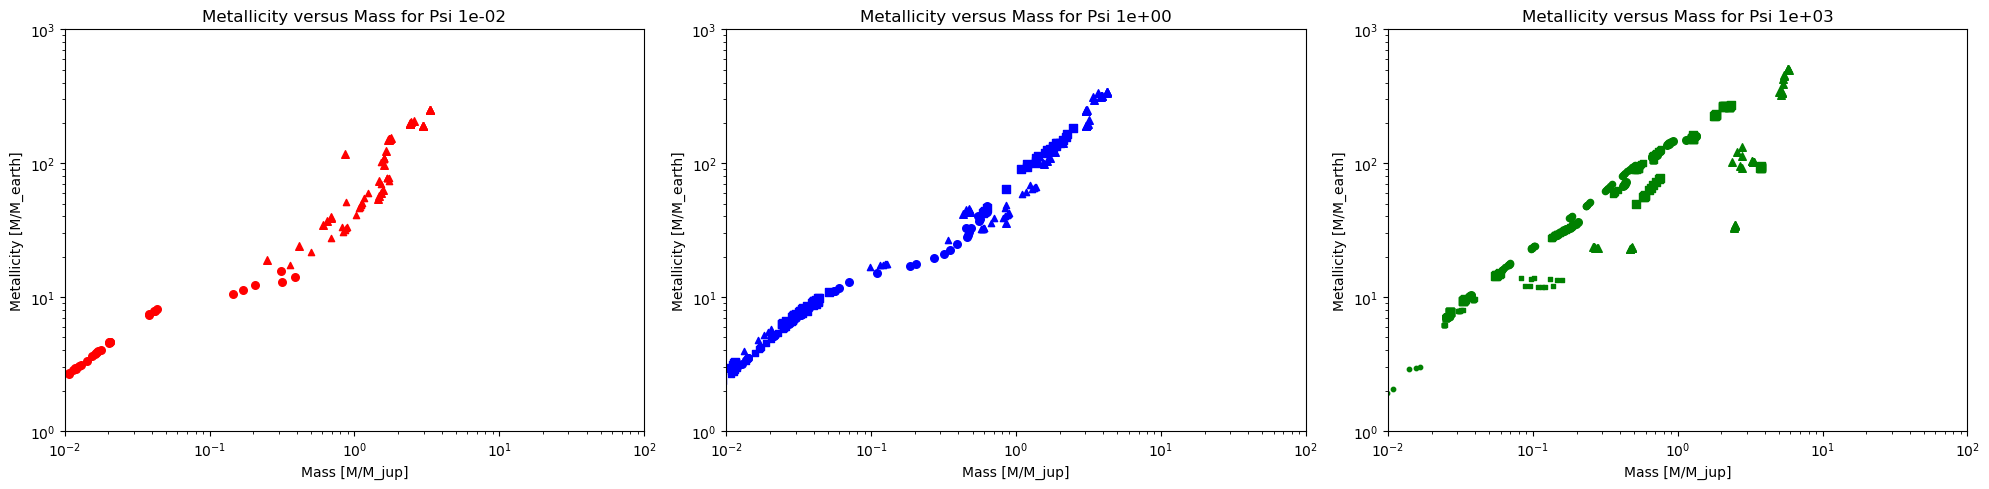

In [ ]:
import json
import numpy as np
import matplotlib.pyplot as plt
from DiscEvolution.constants import *
from DiscEvolution.chemistry import *

fig, axes = plt.subplots(1, 3, figsize=(20, 5))
axes = axes.flatten()

Mdot = 1e-8
numb = 0

for psi in [0.01, 1, 1000]:

    if psi == 0.01:
        color = "red"
    elif psi == 1:
        color = "blue"
    elif psi == 1000:
        color = "green"

    axes[numb].set_title(f"Metallicity versus Mass for Psi {psi:.0e}")
    axes[numb].set_ylabel("Metallicity [M/M_earth]")
    axes[numb].set_xlabel("Mass [M/M_jup]")
    axes[numb].set_xscale("log")
    axes[numb].set_yscale("log")
    axes[numb].set_xlim(1e-2, 1e2)
    axes[numb].set_ylim(1e0, 1e3)

    metallicity_storage = []

    for M in [0.01, 0.05, 0.1]:
        if M == 0.01:
            size = 10
        elif M == 0.05:
            size = 20
        elif M == 0.1:
            size = 30
            
        for Rd in [10, 50, 100]:
            if Rd == 10:
                marker = "^"
            elif Rd == 50:
                marker = "s"
            elif Rd == 100:
                marker = "o"

            try:
                open(f"data/winds_mig_psi{psi}_Mdot{Mdot:.1e}_M{M:.1e}_Rd{Rd:.1e}.json", 'r')
            except FileNotFoundError:
                continue

            with open(f"data/winds_mig_psi{psi}_Mdot{Mdot:.1e}_M{M:.1e}_Rd{Rd:.1e}.json", 'r') as i:
                visc_data = json.load(i)

                t = visc_data["t"]
                Mcs = visc_data["Mcs"]
                Mes = visc_data["Mes"]
                Rp = visc_data["Rp"]
                X_cores = visc_data["X_cores"]
                X_envs = visc_data["X_envs"]

                total_mass = []
                metallicity = []

                for i, core_mass in enumerate(Mcs):
                    total_mass.append(float(core_mass[-1]) + float(Mes[i][-1]))

                    planetary_mol_abund = SimpleCOMolAbund(len(X_cores[0][0]))
                    planetary_mol_abund.data[:] = ((np.array(X_cores[i]))*np.array(Mcs[i]) + np.array(X_envs[i])*np.array(Mes[i]))/total_mass[-1]
                    plan_env_mol_abund = SimpleCOMolAbund(len(X_envs[0][0]))
                    plan_env_mol_abund.data[:] = (np.array(X_envs[i])*np.array(Mes[i]))/total_mass[-1]

                    # collect metallicity and H2O abund data
                    metallicity.append(((np.array(X_cores[i]).sum(0)[-1])*np.array(Mcs[i][-1]) + np.array(X_envs[i]).sum(0)[-1]*np.array(Mes[i][-1]))/total_mass[-1])

                    if any(np.array(metallicity) == float('inf')) or any(np.array(metallicity) == float('-inf')):
                        metallicity.pop(-1)
                        continue

                if len(metallicity) != 0:
                    metallicity_storage += metallicity
                    
                    l1 = axes[numb].scatter(np.array(total_mass)*Mearth/Mjup, np.array(metallicity)*np.array(total_mass), color=color, s=size, marker=marker)

    numb+=1

plt.tight_layout()
fig.show()

Next, we can investigate how planet composition and C/O ratios are affected by psi. Run the following code to see.

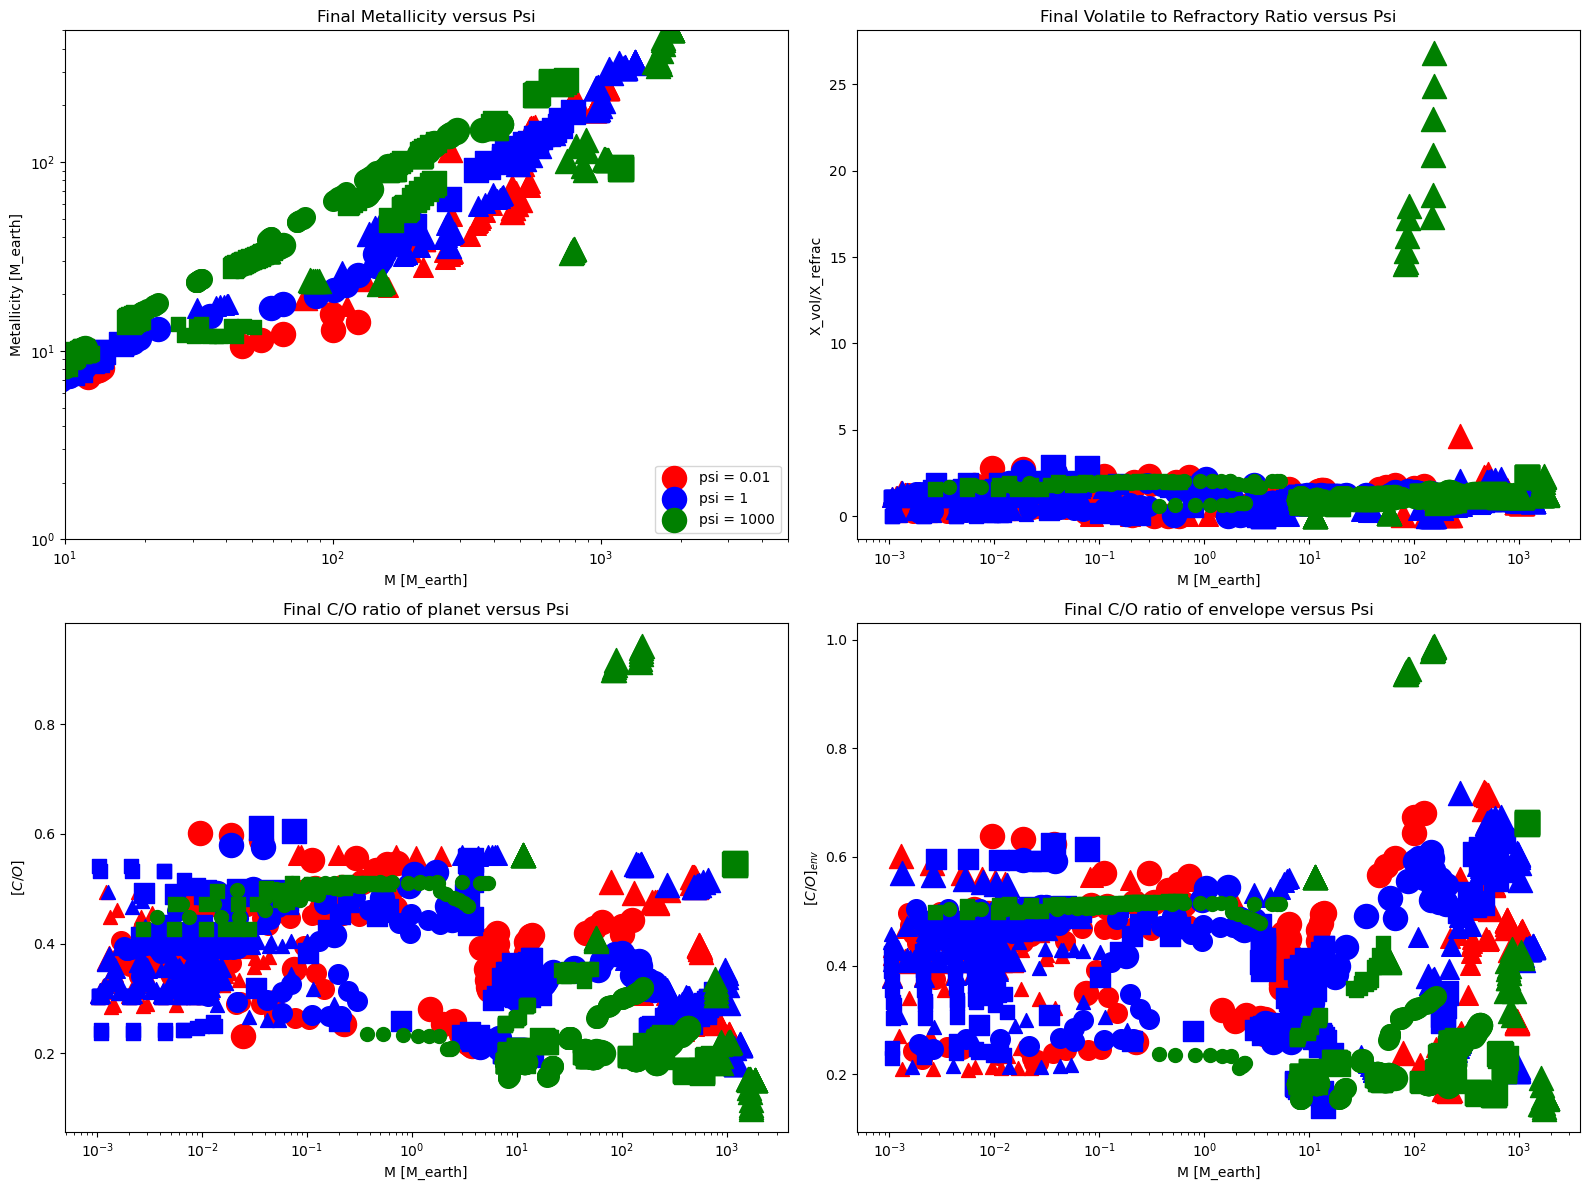

In [ ]:
import json
import numpy as np
import matplotlib.pyplot as plt
from DiscEvolution.chemistry import *

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

axes[0].set_title("Final Metallicity versus Psi")
axes[0].set_ylabel("Metallicity [M_earth]")
axes[0].set_xlabel("M [M_earth]")
axes[0].set_xscale("log")
axes[0].set_yscale("log")
axes[0].set_xlim(1e1, 5e3)
axes[0].set_ylim(1e0, 5e2)

axes[1].set_title("Final Volatile to Refractory Ratio versus Psi")
axes[1].set_ylabel("X_vol/X_refrac")
axes[1].set_xlabel("M [M_earth]")
axes[1].set_xscale("log")

axes[2].set_title("Final C/O ratio of planet versus Psi")
axes[2].set_ylabel("$[C/O]$")
axes[2].set_xlabel("M [M_earth]")
axes[2].set_xscale("log")

axes[3].set_title("Final C/O ratio of envelope versus Psi")
axes[3].set_ylabel("$[C/O]_{env}$")
axes[3].set_xlabel("M [M_earth]")
axes[3].set_xscale("log")

Mdot = 1e-8
color_store = []

for psi in [0.01, 1, 1000]:
    if psi == 0.01:
        color = "red"
    elif psi == 1:
        color = "blue"
    elif psi == 1000:
        color = "green"

    metallicity_storage = []
    vol_to_refrac_storage = []
    CO_ratio_storage = []
    CO_env_ratio_storage = []

    for M in [0.01, 0.05, 0.1]:
        if M == 0.01:
            size = 100
        elif M == 0.05:
            size = 200
        elif M == 0.1:
            size = 300
            
        for Rd in [10, 50, 100]:
            if Rd == 10:
                marker = "^"
            elif Rd == 50:
                marker = "s"
            elif Rd == 100:
                marker = "o"

            try:
                open(f"data/winds_mig_psi{psi}_Mdot{Mdot:.1e}_M{M:.1e}_Rd{Rd:.1e}.json", 'r')
            except FileNotFoundError:
                continue

            with open(f"data/winds_mig_psi{psi}_Mdot{Mdot:.1e}_M{M:.1e}_Rd{Rd:.1e}.json", 'r') as i:
                visc_data = json.load(i)

                t = visc_data["t"]
                Mcs = visc_data["Mcs"]
                Mes = visc_data["Mes"]
                Rp = visc_data["Rp"]
                X_cores = visc_data["X_cores"]
                X_envs = visc_data["X_envs"]

                total_mass = []
                metallicity = []
                vol_to_refrac_ratio = []
                CO_ratio = []
                CO_env_ratio = []
                for i, core_mass in enumerate(Mcs):
                    total_mass.append(float(core_mass[-1]) + float(Mes[i][-1]))

                    planetary_mol_abund = SimpleCOMolAbund(len(X_cores[0][0]))
                    planetary_mol_abund.data[:] = ((np.array(X_cores[i]))*np.array(Mcs[i]) + np.array(X_envs[i])*np.array(Mes[i]))/total_mass[-1]
                    plan_env_mol_abund = SimpleCOMolAbund(len(X_envs[0][0]))
                    plan_env_mol_abund.data[:] = (np.array(X_envs[i])*np.array(Mes[i]))/total_mass[-1]

                    vol_to_refrac_ratio.append(planetary_mol_abund.data[:4].sum(0)[-1]/planetary_mol_abund.data[4:].sum(0)[-1])

                    # collect metallicity and H2O abund data
                    metallicity.append(((np.array(X_cores[i]).sum(0)[-1])*np.array(Mcs[i][-1]) + np.array(X_envs[i]).sum(0)[-1]*np.array(Mes[i][-1]))/total_mass[-1])

                    # now find C/O in envelope and as a whole
                    planetary_atom_abund = planetary_mol_abund.atomic_abundance()
                    CO_ratio.append(planetary_atom_abund.number_abund("C")[-1]/planetary_atom_abund.number_abund("O")[-1])

                    plan_env_atom_abund = plan_env_mol_abund.atomic_abundance()
                    CO_env_ratio.append(plan_env_atom_abund.number_abund("C")[-1]/plan_env_atom_abund.number_abund("O")[-1])

                    if any(np.array(metallicity) == float('inf')) or any(np.array(metallicity) == float('-inf')):
                        metallicity.pop(-1)
                        vol_to_refrac_ratio.pop(-1)
                        CO_ratio.pop(-1)
                        CO_env_ratio.pop(-1)
                        total_mass.pop(-1)
                        continue

                if len(metallicity) != 0:
                    metallicity_storage += metallicity
                    vol_to_refrac_storage += vol_to_refrac_ratio
                    CO_ratio_storage += CO_ratio
                    CO_env_ratio_storage += CO_env_ratio
                    
                    l1 = axes[0].scatter(total_mass, np.array(metallicity)*np.array(total_mass), color=color, s=size, marker=marker)
                    axes[1].scatter(total_mass, vol_to_refrac_ratio, color=color, s=size, marker=marker)
                    axes[2].scatter(total_mass, CO_ratio, color=color, s=size, marker=marker)
                    axes[3].scatter(total_mass, CO_env_ratio, color=color, s=size, marker=marker)

    color_store.append(l1)

axes[0].legend([item for item in color_store], ["psi = 0.01", "psi = 1", "psi = 1000"], loc="lower right")

plt.tight_layout()
fig.show()

We can also see the planet's chemical tracers as a function of their starting and final positions with the following code. I input a slight offset for starting radius so that data points overlap less.

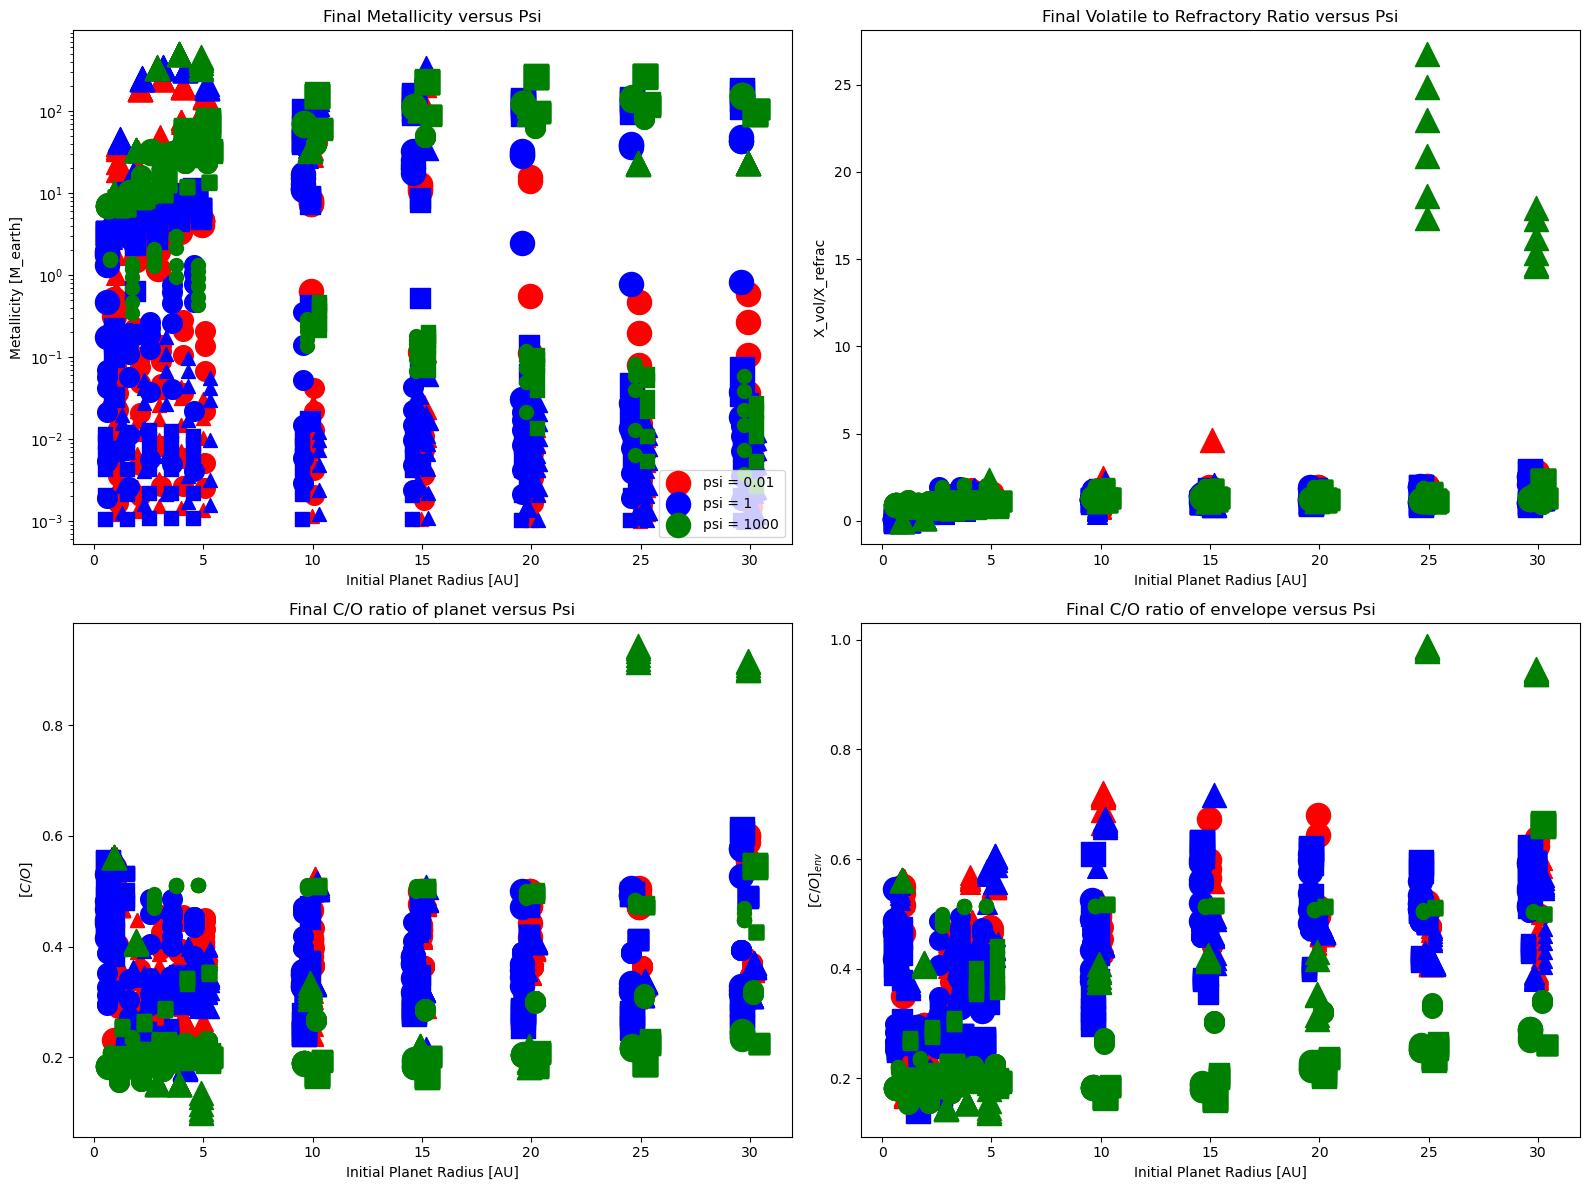

In [ ]:
import json
import numpy as np
import matplotlib.pyplot as plt
from DiscEvolution.chemistry import *
import random

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

axes[0].set_title("Final Metallicity versus Psi")
axes[0].set_ylabel("Metallicity [M_earth]")
axes[0].set_xlabel("Initial Planet Radius [AU]")
axes[0].set_yscale("log")

axes[1].set_title("Final Volatile to Refractory Ratio versus Psi")
axes[1].set_ylabel("X_vol/X_refrac")
axes[1].set_xlabel("Initial Planet Radius [AU]")

axes[2].set_title("Final C/O ratio of planet versus Psi")
axes[2].set_ylabel("$[C/O]$")
axes[2].set_xlabel("Initial Planet Radius [AU]")

axes[3].set_title("Final C/O ratio of envelope versus Psi")
axes[3].set_ylabel("$[C/O]_{env}$")
axes[3].set_xlabel("Initial Planet Radius [AU]")

Mdot = 1e-8
color_store = []

for psi in [0.01, 1, 1000]:
    if psi == 0.01:
        color = "red"
    elif psi == 1:
        color = "blue"
    elif psi == 1000:
        color = "green"

    metallicity_storage = []
    vol_to_refrac_storage = []
    CO_ratio_storage = []
    CO_env_ratio_storage = []

    for M in [0.01, 0.05, 0.1]:
        if M == 0.01:
            size = 100
        elif M == 0.05:
            size = 200
        elif M == 0.1:
            size = 300
            
        for Rd in [10, 50, 100]:
            if Rd == 10:
                marker = "^"
            elif Rd == 50:
                marker = "s"
            elif Rd == 100:
                marker = "o"

            try:
                open(f"data/winds_mig_psi{psi}_Mdot{Mdot:.1e}_M{M:.1e}_Rd{Rd:.1e}.json", 'r')
            except FileNotFoundError:
                continue

            with open(f"data/winds_mig_psi{psi}_Mdot{Mdot:.1e}_M{M:.1e}_Rd{Rd:.1e}.json", 'r') as i:
                visc_data = json.load(i)

                t = visc_data["t"]
                Mcs = visc_data["Mcs"]
                Mes = visc_data["Mes"]
                Rp = visc_data["Rp"]
                X_cores = visc_data["X_cores"]
                X_envs = visc_data["X_envs"]

                offset = random.uniform(-0.5, 0.5)

                total_mass = []
                metallicity = []
                vol_to_refrac_ratio = []
                CO_ratio = []
                CO_env_ratio = []
                starting_radius = []
                for i, core_mass in enumerate(Mcs):
                    total_mass.append(float(core_mass[-1]) + float(Mes[i][-1]))
                    starting_radius.append(Rp[i][0])

                    planetary_mol_abund = SimpleCOMolAbund(len(X_cores[0][0]))
                    planetary_mol_abund.data[:] = ((np.array(X_cores[i]))*np.array(Mcs[i]) + np.array(X_envs[i])*np.array(Mes[i]))/total_mass[-1]
                    plan_env_mol_abund = SimpleCOMolAbund(len(X_envs[0][0]))
                    plan_env_mol_abund.data[:] = (np.array(X_envs[i])*np.array(Mes[i]))/total_mass[-1]

                    vol_to_refrac_ratio.append(planetary_mol_abund.data[:4].sum(0)[-1]/planetary_mol_abund.data[4:].sum(0)[-1])

                    # collect metallicity and H2O abund data
                    metallicity.append(((np.array(X_cores[i]).sum(0)[-1])*np.array(Mcs[i][-1]) + np.array(X_envs[i]).sum(0)[-1]*np.array(Mes[i][-1]))/total_mass[-1])

                    # now find C/O in envelope and as a whole
                    planetary_atom_abund = planetary_mol_abund.atomic_abundance()
                    CO_ratio.append(planetary_atom_abund.number_abund("C")[-1]/planetary_atom_abund.number_abund("O")[-1])

                    plan_env_atom_abund = plan_env_mol_abund.atomic_abundance()
                    CO_env_ratio.append(plan_env_atom_abund.number_abund("C")[-1]/plan_env_atom_abund.number_abund("O")[-1])

                    if any(np.array(metallicity) == float('inf')) or any(np.array(metallicity) == float('-inf')):
                        metallicity.pop(-1)
                        vol_to_refrac_ratio.pop(-1)
                        CO_ratio.pop(-1)
                        CO_env_ratio.pop(-1)
                        starting_radius.pop(-1)
                        total_mass.pop(-1)
                        continue

                if len(metallicity) != 0:
                    metallicity_storage += metallicity
                    vol_to_refrac_storage += vol_to_refrac_ratio
                    CO_ratio_storage += CO_ratio
                    CO_env_ratio_storage += CO_env_ratio
                    
                    l1 = axes[0].scatter(np.array(starting_radius)+offset, np.array(metallicity)*np.array(total_mass), color=color, s=size, marker=marker)
                    axes[1].scatter(np.array(starting_radius)+offset, vol_to_refrac_ratio, color=color, s=size, marker=marker)
                    axes[2].scatter(np.array(starting_radius)+offset, CO_ratio, color=color, s=size, marker=marker)
                    axes[3].scatter(np.array(starting_radius)+offset, CO_env_ratio, color=color, s=size, marker=marker)

    color_store.append(l1)

axes[0].legend([item for item in color_store], ["psi = 0.01", "psi = 1", "psi = 1000"], loc="lower right")

plt.tight_layout()
fig.show()

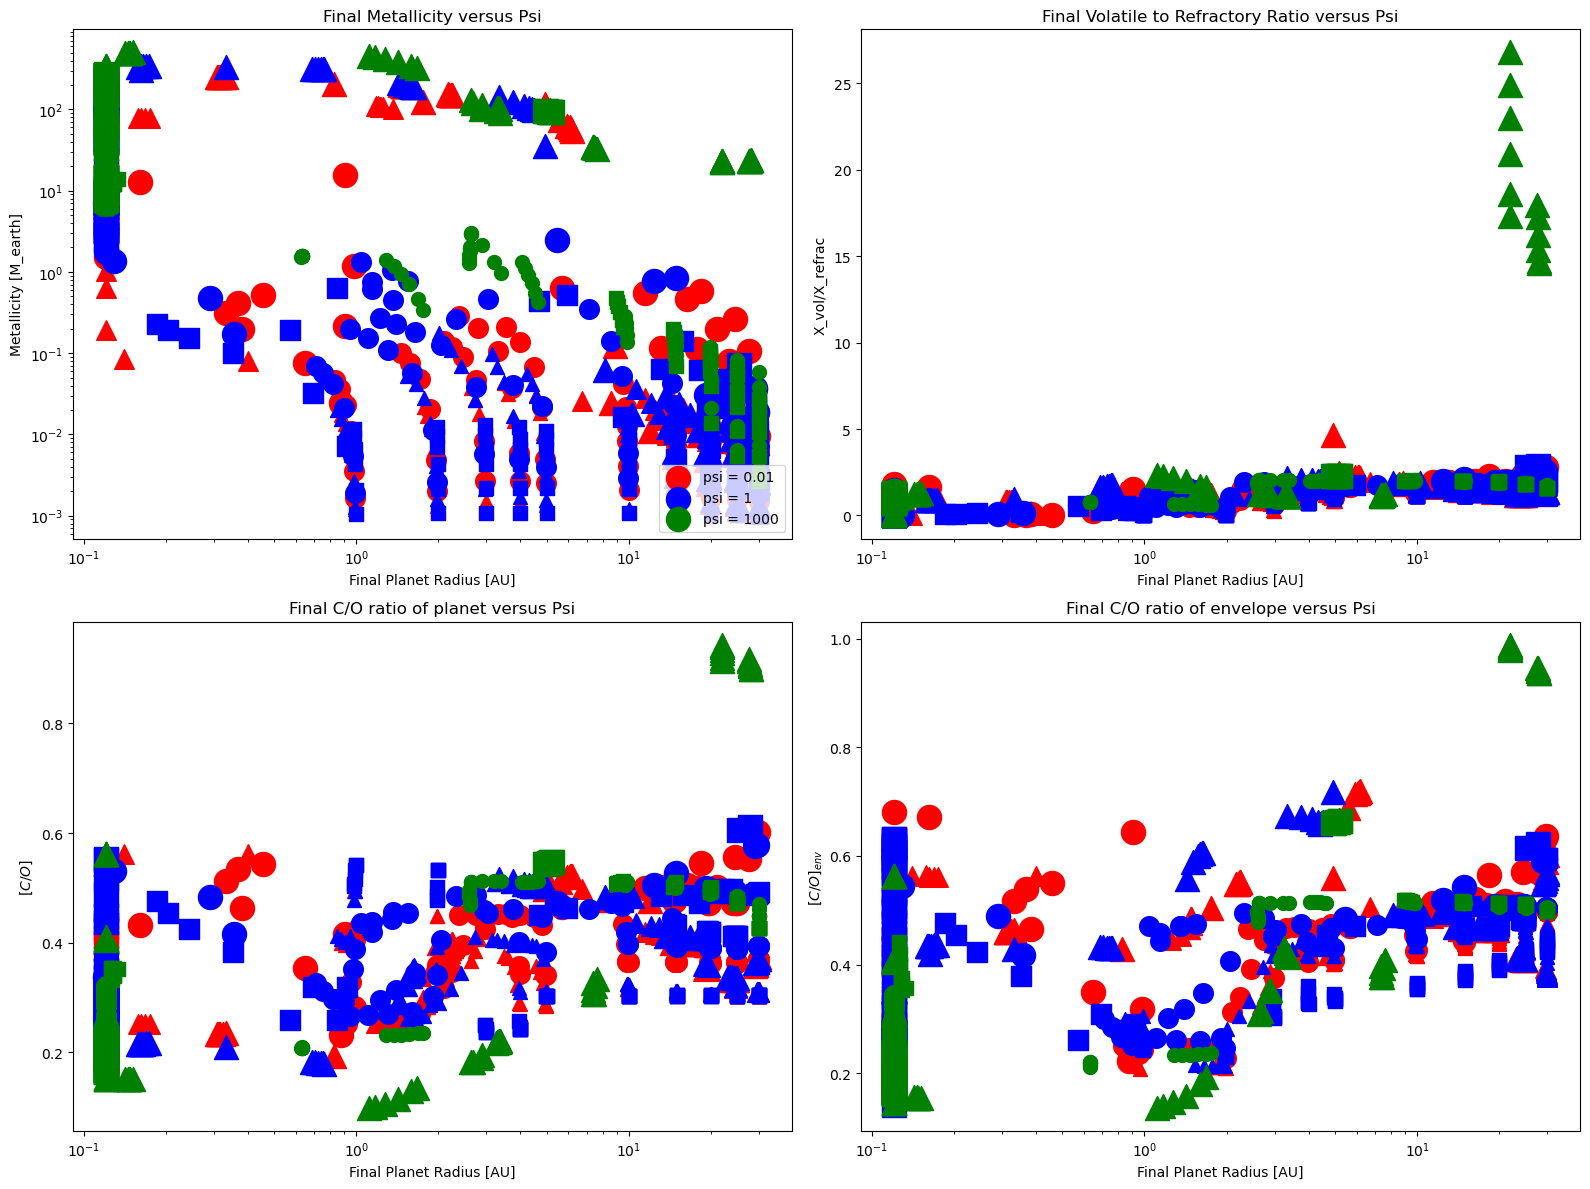

In [ ]:
import json
import numpy as np
import matplotlib.pyplot as plt
from DiscEvolution.chemistry import *

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

axes[0].set_title("Final Metallicity versus Psi")
axes[0].set_ylabel("Metallicity [M_earth]")
axes[0].set_xlabel("Final Planet Radius [AU]")
axes[0].set_yscale("log")
axes[0].set_xscale("log")
#axes[0].set_ylim(1e0, 5e2)

axes[1].set_title("Final Volatile to Refractory Ratio versus Psi")
axes[1].set_ylabel("X_vol/X_refrac")
axes[1].set_xlabel("Final Planet Radius [AU]")
axes[1].set_xscale("log")

axes[2].set_title("Final C/O ratio of planet versus Psi")
axes[2].set_ylabel("$[C/O]$")
axes[2].set_xlabel("Final Planet Radius [AU]")
axes[2].set_xscale("log")

axes[3].set_title("Final C/O ratio of envelope versus Psi")
axes[3].set_ylabel("$[C/O]_{env}$")
axes[3].set_xlabel("Final Planet Radius [AU]")
axes[3].set_xscale("log")

Mdot = 1e-8
color_store = []

for psi in [0.01, 1, 1000]:
    if psi == 0.01:
        color = "red"
    elif psi == 1:
        color = "blue"
    elif psi == 1000:
        color = "green"

    metallicity_storage = []
    vol_to_refrac_storage = []
    CO_ratio_storage = []
    CO_env_ratio_storage = []

    for M in [0.01, 0.05, 0.1]:
        if M == 0.01:
            size = 100
        elif M == 0.05:
            size = 200
        elif M == 0.1:
            size = 300
            
        for Rd in [10, 50, 100]:
            if Rd == 10:
                marker = "^"
            elif Rd == 50:
                marker = "s"
            elif Rd == 100:
                marker = "o"

            try:
                open(f"data/winds_mig_psi{psi}_Mdot{Mdot:.1e}_M{M:.1e}_Rd{Rd:.1e}.json", 'r')
            except FileNotFoundError:
                continue

            with open(f"data/winds_mig_psi{psi}_Mdot{Mdot:.1e}_M{M:.1e}_Rd{Rd:.1e}.json", 'r') as i:
                visc_data = json.load(i)

                t = visc_data["t"]
                Mcs = visc_data["Mcs"]
                Mes = visc_data["Mes"]
                Rp = visc_data["Rp"]
                X_cores = visc_data["X_cores"]
                X_envs = visc_data["X_envs"]

                total_mass = []
                metallicity = []
                vol_to_refrac_ratio = []
                CO_ratio = []
                CO_env_ratio = []
                end_radius = []
                for i, core_mass in enumerate(Mcs):
                    total_mass.append(float(core_mass[-1]) + float(Mes[i][-1]))
                    end_radius.append(Rp[i][-1])

                    planetary_mol_abund = SimpleCOMolAbund(len(X_cores[0][0]))
                    planetary_mol_abund.data[:] = ((np.array(X_cores[i]))*np.array(Mcs[i]) + np.array(X_envs[i])*np.array(Mes[i]))/total_mass[-1]
                    plan_env_mol_abund = SimpleCOMolAbund(len(X_envs[0][0]))
                    plan_env_mol_abund.data[:] = (np.array(X_envs[i])*np.array(Mes[i]))/total_mass[-1]

                    vol_to_refrac_ratio.append(planetary_mol_abund.data[:4].sum(0)[-1]/planetary_mol_abund.data[4:].sum(0)[-1])

                    # collect metallicity and H2O abund data
                    metallicity.append(((np.array(X_cores[i]).sum(0)[-1])*np.array(Mcs[i][-1]) + np.array(X_envs[i]).sum(0)[-1]*np.array(Mes[i][-1]))/total_mass[-1])

                    # now find C/O in envelope and as a whole
                    planetary_atom_abund = planetary_mol_abund.atomic_abundance()
                    CO_ratio.append(planetary_atom_abund.number_abund("C")[-1]/planetary_atom_abund.number_abund("O")[-1])

                    plan_env_atom_abund = plan_env_mol_abund.atomic_abundance()
                    CO_env_ratio.append(plan_env_atom_abund.number_abund("C")[-1]/plan_env_atom_abund.number_abund("O")[-1])

                    if any(np.array(metallicity) == float('inf')) or any(np.array(metallicity) == float('-inf')):
                        metallicity.pop(-1)
                        vol_to_refrac_ratio.pop(-1)
                        CO_ratio.pop(-1)
                        CO_env_ratio.pop(-1)
                        end_radius.pop(-1)
                        total_mass.pop(-1)
                        continue

                if len(metallicity) != 0:
                    metallicity_storage += metallicity
                    vol_to_refrac_storage += vol_to_refrac_ratio
                    CO_ratio_storage += CO_ratio
                    CO_env_ratio_storage += CO_env_ratio
                    
                    l1 = axes[0].scatter(np.array(end_radius), np.array(metallicity)*np.array(total_mass), color=color, s=size, marker=marker)
                    axes[1].scatter(np.array(end_radius), vol_to_refrac_ratio, color=color, s=size, marker=marker)
                    axes[2].scatter(np.array(end_radius), CO_ratio, color=color, s=size, marker=marker)
                    axes[3].scatter(np.array(end_radius), CO_env_ratio, color=color, s=size, marker=marker)

    color_store.append(l1)

axes[0].legend([item for item in color_store], ["psi = 0.01", "psi = 1", "psi = 1000"], loc="lower right")

plt.tight_layout()
plt.show()

Note, if you want to see growth tracks, C/O ratios of planets and other materials, and surface densities of everything in a certain disc, run "run_model_single.py" with the correct configs. It will output a plot that you can then analyze. 

That's all I have to show you! I hope this was informative.